# The Battle of Neighborhoods - New York

## Where to open a Coffee Shop in NYC

### Introduction

This final project explores the best locations for coffee shops throughout the city of New York. Although we might have a feeling that coffee shops are ubiquitous, there are many differences in the number of coffee shops depending on the neighborhood. 

Over 8 million people live in the city and coffee shops became a place where you could get not only coffee, but also other types of snacks and refreshments. With many of them also providing free wi-fi, there are many people who would bring their laptops and work from the coffee shops during the day (this, of course, before the COVID-19 pandemic). 

This report explores which neighborhoods and boroughs of New York City have the biggest number of coffee shops, as well as the best rated ones. Moreover, the study will attempt to answer the questions “Where should I open a coffee shop?” and “Where should I go if I want great coffee in New York?”

### Data

In order to answer the questions mentioned above, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of coffee shops will be obtained via the Foursquare API utilized via the Request library in Python.

### Methodology

• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.
• Foursquare be used to locate all venues and then filtered by coffee shops. Ratings, tips, and likes by users will be counted and added to the dataframe.
• Data will be sorted based on rankings
• Finally, the data be will be visually assessed using graphing from various Python libraries.

### Problem Statement

1.	What is / are the best location(s) for coffee shops in New York City?
2.	In what Neighborhood and/or borough should I open a coffee shop to have the best chance of being successful?
3.	Where would I go in New York City to have the best coffee?

Load Libraries

In [2]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium
! pip install folium
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

     |████████████████████████████████| 94 kB 5.7 MB/s  eta 0:00:01
Done!


My variables

In [2]:
CLIENT_ID = 'PBRE5NG1PBNYVBEGPZMBUJVCQ4IPBNSNG2HNHGINTNWWIHJG' # your Foursquare ID
CLIENT_SECRET = 'PJDUYWI2H1M1CMTLIBF5ZBDS43TT4CPQTMXJYRHLFXLZ2QPN' # your Foursquare Secret
VERSION = '20210107' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PBRE5NG1PBNYVBEGPZMBUJVCQ4IPBNSNG2HNHGINTNWWIHJG
CLIENT_SECRET:PJDUYWI2H1M1CMTLIBF5ZBDS43TT4CPQTMXJYRHLFXLZ2QPN


Functions that will be used later:

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

Now let's get our initial NYC data:

In [4]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
ny_data.shape

(306, 4)

Now that we have our initial data, we can analyze it. We can see below that Manhattan has fewer neighborhoods than the other buroughs.

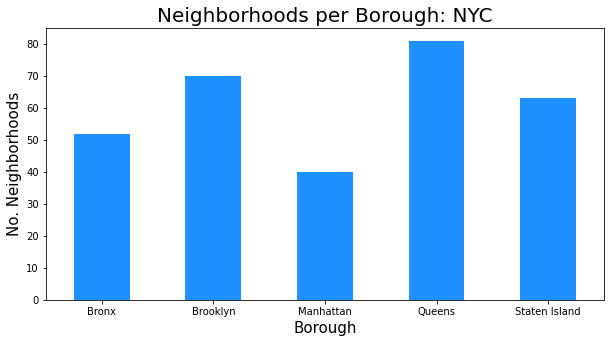

In [6]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Let's analyze further and see how many coffee shops there are in each neighborhood and burough and graph the results.

In [7]:
# queens has most neighborhoods
# prepare neighborhood list that contains Coffee Shops
column_names=['Borough', 'Neighborhood', 'ID','Name']
coffee_shop_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    coffee_shop=venues[venues['Category']=='Coffee Shop']   
    print('(',count,'/',len(ny_data),')','Coffee Shop in '+Neighborhood+', '+Borough+':'+str(len(coffee_shop)))
    print(row)
    for resturant_detail in coffee_shop.values.tolist():
        id, name , category=resturant_detail
        coffee_shop_ny = coffee_shop_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Coffee Shop in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Coffee Shop in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Coffee Shop in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Coffee Shop in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Coffee Shop in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Coffee Shop in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Coffee Shop in Marble Hill, Manhattan:1
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Coffee Shop in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Coffee Shop in Norwood, Bronx:1
['Bronx', 'Norwood', 40.87722415599446, -73.8793907395681]
( 10 / 306 ) Co

( 73 / 306 ) Coffee Shop in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Coffee Shop in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Coffee Shop in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]
( 76 / 306 ) Coffee Shop in Flatlands, Brooklyn:0
['Brooklyn', 'Flatlands', 40.630446043757466, -73.92911302644674]
( 77 / 306 ) Coffee Shop in Mill Island, Brooklyn:0
['Brooklyn', 'Mill Island', 40.606336421685626, -73.90818571777423]
( 78 / 306 ) Coffee Shop in Manhattan Beach, Brooklyn:0
['Brooklyn', 'Manhattan Beach', 40.57791350308657, -73.94353722891886]
( 79 / 306 ) Coffee Shop in Coney Island, Brooklyn:0
['Brooklyn', 'Coney Island', 40.57429256471601, -73.98868295821637]
( 80 / 306 ) Coffee Shop in Bath Beach, Brooklyn:0
['Brooklyn', 'Bath Beach', 40.59951870282238, -73.99875221443519]
( 81 / 306 ) Coffee Shop in Borough Par

( 141 / 306 ) Coffee Shop in Sunnyside, Queens:1
['Queens', 'Sunnyside', 40.74017628351924, -73.92691617561577]
( 142 / 306 ) Coffee Shop in East Elmhurst, Queens:0
['Queens', 'East Elmhurst', 40.76407323883091, -73.86704147658772]
( 143 / 306 ) Coffee Shop in Maspeth, Queens:0
['Queens', 'Maspeth', 40.725427374093606, -73.89621713626859]
( 144 / 306 ) Coffee Shop in Ridgewood, Queens:0
['Queens', 'Ridgewood', 40.70832315613858, -73.90143517559589]
( 145 / 306 ) Coffee Shop in Glendale, Queens:0
['Queens', 'Glendale', 40.70276242967838, -73.87074167435605]
( 146 / 306 ) Coffee Shop in Rego Park, Queens:0
['Queens', 'Rego Park', 40.72897409480735, -73.8578268690537]
( 147 / 306 ) Coffee Shop in Woodhaven, Queens:0
['Queens', 'Woodhaven', 40.68988687915789, -73.8581104655432]
( 148 / 306 ) Coffee Shop in Ozone Park, Queens:0
['Queens', 'Ozone Park', 40.680708468265415, -73.84320266173447]
( 149 / 306 ) Coffee Shop in South Ozone Park, Queens:0
['Queens', 'South Ozone Park', 40.6685495776

( 212 / 306 ) Coffee Shop in New Dorp, Staten Island:1
['Staten Island', 'New Dorp', 40.57257231820632, -74.1164794360638]
( 213 / 306 ) Coffee Shop in Oakwood, Staten Island:0
['Staten Island', 'Oakwood', 40.5584622432888, -74.12156593771896]
( 214 / 306 ) Coffee Shop in Great Kills, Staten Island:0
['Staten Island', 'Great Kills', 40.549480228713605, -74.14932381490992]
( 215 / 306 ) Coffee Shop in Eltingville, Staten Island:0
['Staten Island', 'Eltingville', 40.542230747450745, -74.1643308041936]
( 216 / 306 ) Coffee Shop in Annadale, Staten Island:0
['Staten Island', 'Annadale', 40.53811417474507, -74.17854866165878]
( 217 / 306 ) Coffee Shop in Woodrow, Staten Island:1
['Staten Island', 'Woodrow', 40.541967622888755, -74.20524582480326]
( 218 / 306 ) Coffee Shop in Tottenville, Staten Island:0
['Staten Island', 'Tottenville', 40.50533376115642, -74.24656934235283]
( 219 / 306 ) Coffee Shop in Tompkinsville, Staten Island:0
['Staten Island', 'Tompkinsville', 40.637316067110326, -74

( 278 / 306 ) Coffee Shop in Sunnyside Gardens, Queens:3
['Queens', 'Sunnyside Gardens', 40.74565180608076, -73.91819286431682]
( 279 / 306 ) Coffee Shop in Blissville, Queens:0
['Queens', 'Blissville', 40.73725071694497, -73.93244235260178]
( 280 / 306 ) Coffee Shop in Fulton Ferry, Brooklyn:2
['Brooklyn', 'Fulton Ferry', 40.70328109093014, -73.99550751888415]
( 281 / 306 ) Coffee Shop in Vinegar Hill, Brooklyn:0
['Brooklyn', 'Vinegar Hill', 40.70332149882874, -73.98111603592393]
( 282 / 306 ) Coffee Shop in Weeksville, Brooklyn:0
['Brooklyn', 'Weeksville', 40.67503986503237, -73.93053108817338]
( 283 / 306 ) Coffee Shop in Broadway Junction, Brooklyn:0
['Brooklyn', 'Broadway Junction', 40.67786104769531, -73.90331684852599]
( 284 / 306 ) Coffee Shop in Dumbo, Brooklyn:2
['Brooklyn', 'Dumbo', 40.70317632822692, -73.9887528074504]
( 285 / 306 ) Coffee Shop in Manor Heights, Staten Island:0
['Staten Island', 'Manor Heights', 40.60180957631444, -74.12059399718001]
( 286 / 306 ) Coffee Sh

In [8]:
# Save the information so far to a .csv file due to limited calls on FourSquare
coffee_shop_ny.to_csv('coffee_shop_ny_tocsv1.csv') 

In [9]:
coffee_shop_ny = pd.read_csv('coffee_shop_ny_tocsv1.csv')
coffee_shop_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
225,225,Brooklyn,Dumbo,590de1ce018cbb785fcc206e,FEED Shop & Cafe
226,226,Bronx,Kingsbridge Heights,4b71c776f964a520fb5b2de3,Perista
227,227,Manhattan,Hudson Yards,5c8d246c492822003a5a5a6e,Blue Bottle Coffee
228,228,Manhattan,Hudson Yards,4fd09d80e4b0e0b51ce2445e,Starbucks
229,229,Manhattan,Hudson Yards,5c8d4eb71f8ed6002c94f624,Jack’s Stir Brew Coffee


In [10]:
coffee_shop_ny.shape

(230, 5)

As we continue our analysis, we see below that although Manhattan had fewer neighborhoods, it has the highest number of coffee shops. Additionally, we can see how many restaurants the top 6 neighborhoods have. The neighborhood of Financial District has the highest number of coffee shops in all of NYC.

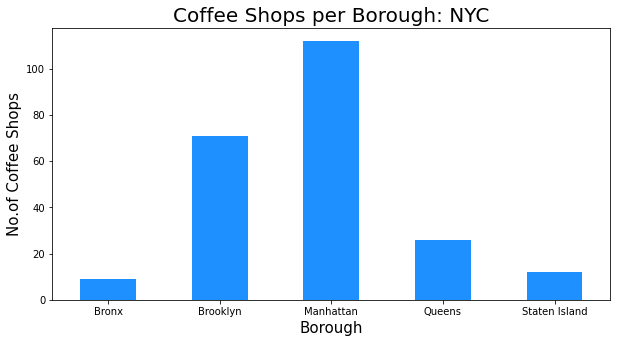

In [11]:
coffee_shop_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Coffee Shops per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Coffee Shops', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

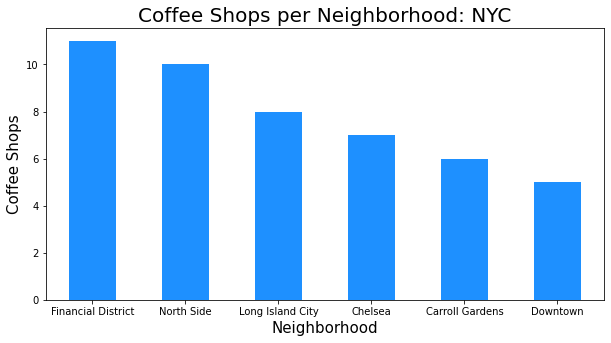

In [12]:
NOofNeigh = 6 # top number for graphing all the same past 6
coffee_shop_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Coffee Shops per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Coffee Shops', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [12]:
coffee_shop_ny[coffee_shop_ny['Neighborhood']=='Financial District']

,Unnamed: 0,Borough,Neighborhood,ID,Name
143,143,Manhattan,Financial District,574456e5498e39c73d234da1,Black Fox Coffee Co.
144,144,Manhattan,Financial District,5ef8e6aef272db0008a81a76,Blue Bottle
145,145,Manhattan,Financial District,561a8cd8498ed81f4384d0aa,La Colombe Torrefaction
146,146,Manhattan,Financial District,5cf965947564f7002c79aa21,For Five Coffee Roasters
147,147,Manhattan,Financial District,500d3cede4b0f6804faa90a8,Blue Spoon Coffee Co.
148,148,Manhattan,Financial District,4a9ff5d9f964a520ba3d20e3,Starbucks
149,149,Manhattan,Financial District,566de7e3498e30e4798117ae,Voyager Espresso
150,150,Manhattan,Financial District,5f11ef5e938b7c3b5ead3c4f,Suited
151,151,Manhattan,Financial District,5985db5e4420d80bedd5e6ef,Boundless Plains Espresso
152,152,Manhattan,Financial District,5893aa7e1e1de501d95e372e,Café Grumpy


In [13]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
coffee_shop_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in coffee_shop_ny.values.tolist():
    Unnamned, Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(coffee_shop_ny),')','processed')
    coffee_shop_stats_ny = coffee_shop_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
coffee_shop_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '600307cc9fc7d574b257e6a0'}, 'response': {'venue': {'id': '57655be738faa66160da7527', 'name': 'Starbucks', 'contact': {}, 'location': {'address': '50 W 225th St', 'lat': 40.873754554218515, 'lng': -73.90861305343668, 'labeledLatLngs': [{'label': 'display', 'lat': 40.873754554218515, 'lng': -73.90861305343668}, {'label': 'entrance', 'lat': 40.873502, 'lng': -73.907986}], 'postalCode': '10463', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['50 W 225th St', 'New York, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/57655be738faa66160da7527', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'c

{'meta': {'code': 200, 'requestId': '600307cc884093478772ed19'}, 'response': {'venue': {'id': '4bb62b326edc76b05d80301c', 'name': 'Liberty Donut & Coffee Shop', 'contact': {'phone': '7188236800', 'formattedPhone': '(718) 823-6800'}, 'location': {'address': '2059 Williamsbridge Rd', 'crossStreet': 'at Lydig Ave', 'lat': 40.85533922011825, 'lng': -73.85533281832504, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85533922011825, 'lng': -73.85533281832504}, {'label': 'entrance', 'lat': 40.855265, 'lng': -73.855457}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2059 Williamsbridge Rd (at Lydig Ave)', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/liberty-donut--coffee-shop/4bb62b326edc76b05d80301c', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_

{'meta': {'code': 200, 'requestId': '600307cd2e715e58ded9cd07'}, 'response': {'venue': {'id': '4baa3cfff964a52081563ae3', 'name': 'Prospect Coffee Shop', 'contact': {}, 'location': {'address': '1309', 'crossStreet': 'Prospect Ave', 'lat': 40.83757698149015, 'lng': -73.88083923833605, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83757698149015, 'lng': -73.88083923833605}], 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1309 (Prospect Ave)', 'Bronx, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/prospect-coffee-shop/4baa3cfff964a52081563ae3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 0, 'groups':

{'meta': {'code': 200, 'requestId': '600307cd76ecee3013a28f10'}, 'response': {'venue': {'id': '575467b1498e848fce847ca1', 'name': 'Pueblo Querido Coffee Roasters', 'contact': {'phone': '9293462986', 'formattedPhone': '(929) 346-2986', 'twitter': 'pqcoffee', 'instagram': 'pqcoffee'}, 'location': {'address': '195 Greenpoint Ave', 'crossStreet': 'McGuinness Blvd.', 'lat': 40.730526, 'lng': -73.951822, 'labeledLatLngs': [{'label': 'display', 'lat': 40.730526, 'lng': -73.951822}, {'label': 'entrance', 'lat': 40.73051, 'lng': -73.951834}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['195 Greenpoint Ave (McGuinness Blvd.)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pueblo-querido-coffee-roasters/575467b1498e848fce847ca1', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://

{'meta': {'code': 200, 'requestId': '600307cedbed4b2397f495c2'}, 'response': {'venue': {'id': '58b6e16ffc73d40233da9715', 'name': 'odd fox', 'contact': {}, 'location': {'address': '984 Manhattan Ave', 'crossStreet': 'India & Huron', 'lat': 40.73267268846633, 'lng': -73.95454999352046, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73267268846633, 'lng': -73.95454999352046}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['984 Manhattan Ave (India & Huron)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/odd-fox/58b6e16ffc73d40233da9715', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': 

{'meta': {'code': 200, 'requestId': '600307cfb16446703bae0dec'}, 'response': {'venue': {'id': '576eb1f5cd10a371033f7ad6', 'name': 'Maman', 'contact': {}, 'location': {'address': '80 Kent St', 'crossStreet': 'at Franklin St', 'lat': 40.730446, 'lng': -73.958133, 'labeledLatLngs': [{'label': 'display', 'lat': 40.730446, 'lng': -73.958133}], 'postalCode': '11249', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['80 Kent St (at Franklin St)', 'New York, NY 11249', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/maman/576eb1f5cd10a371033f7ad6', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categor

{'meta': {'code': 200, 'requestId': '600307cfca6cb155478774e7'}, 'response': {'venue': {'id': '4d8f7d48d265236a02c72117', 'name': 'Upright Coffee', 'contact': {'phone': '7182159910', 'formattedPhone': '(718) 215-9910', 'twitter': 'uprightcoffee'}, 'location': {'address': '860 Manhattan Ave', 'crossStreet': 'at Milton St', 'lat': 40.72933199515132, 'lng': -73.9538915154595, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72933199515132, 'lng': -73.9538915154595}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['860 Manhattan Ave (at Milton St)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/upright-coffee/4d8f7d48d265236a02c72117', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id

                         ID       Name  Likes  Rating  Tips
0  4b59aedcf964a520999228e3  Starbucks    129     6.5    37
( 14 / 230 ) processed
{'meta': {'code': 200, 'requestId': '600307d0e53c096fdfc9e704'}, 'response': {'venue': {'id': '5172b2d4498e646485496d05', 'name': 'Coffee Mob', 'contact': {'twitter': 'thecoffeemob'}, 'location': {'address': '1514 Newkirk Ave', 'crossStreet': 'at E 16th St', 'lat': 40.635841273905065, 'lng': -73.96256072887337, 'labeledLatLngs': [{'label': 'display', 'lat': 40.635841273905065, 'lng': -73.96256072887337}, {'label': 'entrance', 'lat': 40.635667, 'lng': -73.96279}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1514 Newkirk Ave (at E 16th St)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/coffee-mob/5172b2d4498e646485496d05', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName'

{'meta': {'code': 200, 'requestId': '600307d078a0a07d3b2b9368'}, 'response': {'venue': {'id': '4a2407e6f964a520ef7d1fe3', 'name': 'Sit & Wonder', 'contact': {'phone': '7186220299', 'formattedPhone': '(718) 622-0299', 'twitter': 'sitandwonder', 'facebook': '219220151432590', 'facebookUsername': 'SitandWonder.org', 'facebookName': 'Sit & Wonder'}, 'location': {'address': '688 Washington Ave', 'crossStreet': 'btwn Prospect Pl & St Marks Ave', 'lat': 40.67735699650139, 'lng': -73.96386086940765, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67735699650139, 'lng': -73.96386086940765}, {'label': 'entrance', 'lat': 40.677371, 'lng': -73.963824}], 'postalCode': '11238', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['688 Washington Ave (btwn Prospect Pl & St Marks Ave)', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sit--wonder/4a2407e6f964a520ef7d1fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', '

{'meta': {'code': 200, 'requestId': '600307d12e715e58ded9da1b'}, 'response': {'venue': {'id': '5d8663bddfbfcc0007278c66', 'name': 'Konditori', 'contact': {}, 'location': {'address': '297 Broadway', 'crossStreet': 'Entrance on Marcy Av', 'lat': 40.708614, 'lng': -73.957906, 'labeledLatLngs': [{'label': 'display', 'lat': 40.708614, 'lng': -73.957906}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['297 Broadway (Entrance on Marcy Av)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/konditori/5d8663bddfbfcc0007278c66', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'h

{'meta': {'code': 200, 'requestId': '600307d178a0a07d3b2b97ce'}, 'response': {'venue': {'id': '55e9fe71498e8edb034385a7', 'name': 'Dweebs', 'contact': {}, 'location': {'address': '1434 Dekalb Ave', 'crossStreet': 'btwn Wilson & Knickerbocker Ave', 'lat': 40.700507067885084, 'lng': -73.92279516968233, 'labeledLatLngs': [{'label': 'display', 'lat': 40.700507067885084, 'lng': -73.92279516968233}, {'label': 'entrance', 'lat': 40.700505, 'lng': -73.922829}], 'postalCode': '11237', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1434 Dekalb Ave (btwn Wilson & Knickerbocker Ave)', 'Brooklyn, NY 11237', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dweebs/55e9fe71498e8edb034385a7', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': 

{'meta': {'code': 200, 'requestId': '600307d2f77af50c9bc6ff26'}, 'response': {'venue': {'id': '56b8c8aa498e095e6ff4b065', 'name': 'Brooklyn Kava', 'contact': {}, 'location': {'address': '191 Suydam St.', 'crossStreet': 'Wilson Ave.', 'lat': 40.70039841380254, 'lng': -73.92551762093899, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70039841380254, 'lng': -73.92551762093899}], 'postalCode': '11221', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['191 Suydam St. (Wilson Ave.)', 'Brooklyn, NY 11221', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/brooklyn-kava/56b8c8aa498e095e6ff4b065', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 10}, 'url': 'http://brooklynkava.com', 'price': {'tier'

{'meta': {'code': 200, 'requestId': '600307d2ac79113354f3c515'}, 'response': {'venue': {'id': '5662f5d3498e53d321cd3456', 'name': 'S,T Coffee', 'contact': {}, 'location': {'address': '343 Tompkins Ave', 'lat': 40.68606948852539, 'lng': -73.9443130493164, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68606948852539, 'lng': -73.9443130493164}], 'postalCode': '11216', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['343 Tompkins Ave', 'Brooklyn, NY 11216', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/st-coffee/5662f5d3498e53d321cd3456', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 9, 'groups': [{'type':

{'meta': {'code': 200, 'requestId': '600307d2ba07166a6a580caa'}, 'response': {'venue': {'id': '4de26e06814df7ebdc14af8b', 'name': 'Vineapple Cafe', 'contact': {'phone': '3477991035', 'formattedPhone': '(347) 799-1035', 'twitter': 'vineapple71', 'instagram': 'vineapple71', 'facebook': '151802771550513', 'facebookUsername': 'Vineapple', 'facebookName': 'Vineapple'}, 'location': {'address': '71 Pineapple St', 'crossStreet': 'btwn Henry & Hicks St', 'lat': 40.69829747774025, 'lng': -73.99306207895279, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69829747774025, 'lng': -73.99306207895279}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['71 Pineapple St (btwn Henry & Hicks St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/vineapple-cafe/4de26e06814df7ebdc14af8b', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName':

{'meta': {'code': 200, 'requestId': '600307d2e93b3e0bd59161da'}, 'response': {'venue': {'id': '59d7872e5a2c911745c2e8ca', 'name': 'Joe Coffee', 'contact': {'phone': '3474220304', 'formattedPhone': '(347) 422-0304', 'twitter': 'joecoffeenyc', 'facebook': '218350858817750', 'facebookUsername': 'JoeCoffeeBrooklynHeights', 'facebookName': 'Joe Coffee Company'}, 'location': {'address': '102 Hicks St', 'lat': 40.6986734, 'lng': -73.9943579, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6986734, 'lng': -73.9943579}], 'postalCode': '11201', 'cc': 'US', 'neighborhood': 'Brooklyn Heights', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['102 Hicks St', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joe-coffee/59d7872e5a2c911745c2e8ca', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v

{'meta': {'code': 200, 'requestId': '600307d32514a902849d09fa'}, 'response': {'venue': {'id': '580d0a4838fa8cf0e28e76c2', 'name': 'Espresso Me', 'contact': {}, 'location': {'address': '88 Atlantic Avenue', 'crossStreet': 'Hicks Street', 'lat': 40.69095211398312, 'lng': -73.99744811084277, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69095211398312, 'lng': -73.99744811084277}], 'postalCode': '11201', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88 Atlantic Avenue (Hicks Street)', 'New York, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/espresso-me/580d0a4838fa8cf0e28e76c2', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1c9941735', 'name': 'Ice Cream Shop', 'pluralName': 'Ice Cream Shops

{'meta': {'code': 200, 'requestId': '600307d3ff7d1a6e8979c1ff'}, 'response': {'venue': {'id': '58d933702f91cb026f478e38', 'name': 'East One Coffee Roasters', 'contact': {'phone': '3479874919', 'formattedPhone': '(347) 987-4919', 'twitter': 'eastonecoffee', 'instagram': 'eastonecoffee', 'facebook': '1793648794186816', 'facebookUsername': 'eastonecoffee', 'facebookName': 'East One Coffee Roasters'}, 'location': {'address': '384 Court St', 'crossStreet': 'at Carroll St', 'lat': 40.681128035266816, 'lng': -73.99652634325895, 'labeledLatLngs': [{'label': 'display', 'lat': 40.681128035266816, 'lng': -73.99652634325895}], 'postalCode': '11231', 'cc': 'US', 'neighborhood': 'Carroll Gardens', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['384 Court St (at Carroll St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/east-one-coffee-roasters/58d933702f91cb026f478e38', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name'

{'meta': {'code': 200, 'requestId': '600307d3ba07166a6a581048'}, 'response': {'venue': {'id': '5afda093012358002cfdbd9b', 'name': 'Planted', 'contact': {'phone': '9177045207', 'formattedPhone': '(917) 704-5207'}, 'location': {'address': '333 Smith St', 'lat': 40.680558, 'lng': -73.994584, 'labeledLatLngs': [{'label': 'display', 'lat': 40.680558, 'lng': -73.994584}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['333 Smith St', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/planted/5afda093012358002cfdbd9b', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.

{'meta': {'code': 200, 'requestId': '600307d476ecee3013a2a452'}, 'response': {'venue': {'id': '5970b104b9ac383dd3f059c2', 'name': 'Velvette Brew', 'contact': {'instagram': 'velvettebrew', 'facebook': '222623231594571', 'facebookUsername': 'velvettebrew', 'facebookName': 'Velvette Brew'}, 'location': {'address': '251 Smith St', 'lat': 40.68326476849194, 'lng': -73.99275423214551, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68326476849194, 'lng': -73.99275423214551}], 'postalCode': '11231', 'cc': 'US', 'neighborhood': 'Boerum Hill', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['251 Smith St', 'New York, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/velvette-brew/5970b104b9ac383dd3f059c2', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '600307d49e0a315fefa8a47e'}, 'response': {'venue': {'id': '4cf111d0899c6ea8bf48eec1', 'name': 'Red Hook coffee shop', 'contact': {'phone': '7184889730', 'formattedPhone': '(718) 488-9730'}, 'location': {'address': '327 Van Brunt St', 'crossStreet': 'Sullivan St', 'lat': 40.677904, 'lng': -74.011993, 'labeledLatLngs': [{'label': 'display', 'lat': 40.677904, 'lng': -74.011993}, {'label': 'entrance', 'lat': 40.67794, 'lng': -74.012046}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['327 Van Brunt St (Sullivan St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/red-hook-coffee-shop/4cf111d0899c6ea8bf48eec1', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '600307d5f5b91f33479612b9'}, 'response': {'venue': {'id': '5e2c4d6803cb1200089cbb9e', 'name': 'Hungry Ghost', 'contact': {}, 'location': {'address': '156 7th Ave', 'crossStreet': 'Garfield', 'lat': 40.672276, 'lng': -73.977265, 'labeledLatLngs': [{'label': 'display', 'lat': 40.672276, 'lng': -73.977265}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['156 7th Ave (Garfield)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hungry-ghost/5e2c4d6803cb1200089cbb9e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'url': 'https://www.hungryghostcoffee.com', 'price': {'tier': 1, 'message': 'Cheap', 'currency': 

{'meta': {'code': 200, 'requestId': '600307d5e1508a23af167dc2'}, 'response': {'venue': {'id': '4a64e954f964a520f6c61fe3', 'name': 'Café Regular du Nord', 'contact': {'phone': '7187830673', 'formattedPhone': '(718) 783-0673', 'twitter': 'caferegular', 'facebook': '408074899309454', 'facebookUsername': 'CafeRegular', 'facebookName': 'Cafe Regular'}, 'location': {'address': '158 Berkeley Pl', 'crossStreet': 'btwn 6th & 7th Ave', 'lat': 40.67515658418125, 'lng': -73.97530161274537, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67515658418125, 'lng': -73.97530161274537}, {'label': 'entrance', 'lat': 40.675178, 'lng': -73.975489}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['158 Berkeley Pl (btwn 6th & 7th Ave)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caf%C3%A9-regular-du-nord/4a64e954f964a520f6c61fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee S

{'meta': {'code': 200, 'requestId': '600307d6cb7cea4da400c8ea'}, 'response': {'venue': {'id': '5e4855647542960008d9a268', 'name': 'Marine Park Coffee', 'contact': {}, 'location': {'address': '3411 Ave S', 'crossStreet': 'East 34th Street', 'lat': 40.609023, 'lng': -73.93248, 'labeledLatLngs': [{'label': 'display', 'lat': 40.609023, 'lng': -73.93248}], 'postalCode': '11234', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3411 Ave S (East 34th Street)', 'New York, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/marine-park-coffee/5e4855647542960008d9a268', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'cou

{'meta': {'code': 200, 'requestId': '600307d6f5b91f334796163f'}, 'response': {'venue': {'id': '59946d393b830745ce06bd87', 'name': 'Starbucks', 'contact': {'twitter': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '4 Chase Metrotech Ctr', 'lat': 40.693063052751626, 'lng': -73.98360951708158, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693063052751626, 'lng': -73.98360951708158}], 'postalCode': '11245', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4 Chase Metrotech Ctr', 'Brooklyn, NY 11245', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/59946d393b830745ce06bd87', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'st

{'meta': {'code': 200, 'requestId': '600307d7aca2493433d31921'}, 'response': {'venue': {'id': '5d90bcd9bdcf690008c68e47', 'name': 'IXV', 'contact': {}, 'location': {'lat': 40.684794, 'lng': -73.981398, 'labeledLatLngs': [{'label': 'display', 'lat': 40.684794, 'lng': -73.981398}], 'postalCode': '11217', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ixv/5d90bcd9bdcf690008c68e47', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 13, 'groups': [{'type': 'others', 'count': 13, 'items': []}], 'summary': '13 Likes'}, 'dislike': False, 'ok': False,

{'meta': {'code': 200, 'requestId': '600307d71cd7b409992ffd7d'}, 'response': {'venue': {'id': '5e4aaa1ea1c4c20008f3fbfb', 'name': 'Hamlet Coffee Company', 'contact': {'instagram': 'hamletcoffeecompany'}, 'location': {'address': '465 Rogers Ave', 'lat': 40.66084, 'lng': -73.95352, 'labeledLatLngs': [{'label': 'display', 'lat': 40.66084, 'lng': -73.95352}], 'postalCode': '11225', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['465 Rogers Ave', 'Brooklyn, NY 11225', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hamlet-coffee-company/5e4aaa1ea1c4c20008f3fbfb', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 2, 

{'meta': {'code': 200, 'requestId': '600307d72ab32f78861494e8'}, 'response': {'venue': {'id': '4f5f67eae4b0f5c1d143a686', 'name': 'Jassar Gourmet Deli', 'contact': {'phone': '7182771178', 'formattedPhone': '(718) 277-1178'}, 'location': {'address': '2932 Pitkin Ave', 'lat': 40.67761698488269, 'lng': -73.864208353719, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67761698488269, 'lng': -73.864208353719}, {'label': 'entrance', 'lat': 40.676377, 'lng': -73.863706}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2932 Pitkin Ave', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jassar-gourmet-deli/4f5f67eae4b0f5c1d143a686', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4d4b71

{'meta': {'code': 200, 'requestId': '600307d80bf2b4487860b519'}, 'response': {'venue': {'id': '55aad5ad498e3edffdc18580', 'name': 'City of Saints Coffee Roasters', 'contact': {'phone': '9299005484', 'formattedPhone': '(929) 900-5484', 'twitter': 'cityofsaintscr', 'instagram': 'cityofsaintscoffee', 'facebook': '541919979270333', 'facebookName': 'City of Saints Coffee Roasters'}, 'location': {'address': '299 Meserole St', 'lat': 40.70886064129511, 'lng': -73.93602911739248, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70886064129511, 'lng': -73.93602911739248}, {'label': 'entrance', 'lat': 40.708847, 'lng': -73.936042}], 'postalCode': '11206', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['299 Meserole St', 'Brooklyn, NY 11206', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/city-of-saints-coffee-roasters/55aad5ad498e3edffdc18580', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'C

{'meta': {'code': 200, 'requestId': '600307d83d228505a14f6fe5'}, 'response': {'venue': {'id': '546e7431498ea09f2b9152be', 'name': 'Sweatshop', 'contact': {'phone': '9179607232', 'formattedPhone': '(917) 960-7232', 'twitter': 'sweatshop_nyc', 'facebook': '561532637270591', 'facebookUsername': 'sweatshopcollective', 'facebookName': 'Sweatshop'}, 'location': {'address': '232 Metropolitan Ave', 'lat': 40.715089868805926, 'lng': -73.95973374883259, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715089868805926, 'lng': -73.95973374883259}, {'label': 'entrance', 'lat': 40.714937, 'lng': -73.959704}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['232 Metropolitan Ave', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sweatshop/546e7431498ea09f2b9152be', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'i

{'meta': {'code': 200, 'requestId': '600307d976ecee3013a2b234'}, 'response': {'venue': {'id': '5d839388ebc5f800089cea77', 'name': 'Daymoves', 'contact': {'instagram': 'daymovesbk'}, 'location': {'address': '295 Grand St', 'crossStreet': 'Havemeyer St', 'lat': 40.71310397344715, 'lng': -73.9572586119175, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71310397344715, 'lng': -73.9572586119175}], 'postalCode': '10002', 'cc': 'US', 'neighborhood': 'Williamsburg, Brooklyn, NY', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['295 Grand St (Havemeyer St)', 'Brooklyn, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/daymoves/5d839388ebc5f800089cea77', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d116941735', 'name

{'meta': {'code': 200, 'requestId': '600307d9ce054c46cc1e1186'}, 'response': {'venue': {'id': '4ed1077a4690a03b5e13c348', 'name': 'Black Brick', 'contact': {'phone': '7183840075', 'formattedPhone': '(718) 384-0075'}, 'location': {'address': '300 Bedford Ave', 'crossStreet': 'btwn Grand & S 1st St', 'lat': 40.714184577749386, 'lng': -73.96155735867296, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714184577749386, 'lng': -73.96155735867296}, {'label': 'entrance', 'lat': 40.714178, 'lng': -73.961624}], 'postalCode': '11249', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['300 Bedford Ave (btwn Grand & S 1st St)', 'Brooklyn, NY 11249', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/black-brick/4ed1077a4690a03b5e13c348', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_

{'meta': {'code': 200, 'requestId': '600307d909586a1e9c37e314'}, 'response': {'venue': {'id': '5dcece7b5dd031000867b62e', 'name': 'Hungry Ghost', 'contact': {'instagram': 'hungryghostcoffee'}, 'location': {'address': '231 Bedford Avenue', 'crossStreet': 'North 4th Street & Bedford Avenue', 'lat': 40.716089, 'lng': -73.959484, 'labeledLatLngs': [{'label': 'display', 'lat': 40.716089, 'lng': -73.959484}], 'postalCode': '11211', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['231 Bedford Avenue (North 4th Street & Bedford Avenue)', 'New York, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hungry-ghost/5dcece7b5dd031000867b62e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, '

{'meta': {'code': 200, 'requestId': '600307da4c759760ac06db57'}, 'response': {'venue': {'id': '4eba99d3be7b1e562036cb46', 'name': 'Partners Coffee', 'contact': {'phone': '3475860063', 'formattedPhone': '(347) 586-0063', 'twitter': 'partners_coffee', 'instagram': 'partnerscoffee', 'facebook': '166431326755354', 'facebookUsername': 'partnerscoffeeroasters', 'facebookName': 'Partners Coffee'}, 'location': {'address': '125 N 6th St', 'crossStreet': 'btwn Bedford Ave & Berry St', 'lat': 40.718012, 'lng': -73.959174, 'labeledLatLngs': [{'label': 'display', 'lat': 40.718012, 'lng': -73.959174}, {'label': 'entrance', 'lat': 40.717943, 'lng': -73.959215}], 'postalCode': '11249', 'cc': 'US', 'neighborhood': 'Williamsburg', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['125 N 6th St (btwn Bedford Ave & Berry St)', 'Brooklyn, NY 11249', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/partners-coffee/4eba99d3be7b1e562036cb46', 'categories': [{'id':

{'meta': {'code': 200, 'requestId': '600307dace054c46cc1e14d7'}, 'response': {'venue': {'id': '5b86febb3731ee002c98aa4b', 'name': 'ppl', 'contact': {'instagram': 'pplnyc'}, 'location': {'address': '189 Roebling St', 'crossStreet': 'at S 1st St', 'lat': 40.71282137546778, 'lng': -73.95844548940659, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71282137546778, 'lng': -73.95844548940659}, {'label': 'entrance', 'lat': 40.712871, 'lng': -73.958455}], 'postalCode': '11211', 'cc': 'US', 'neighborhood': 'Williamsburg', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['189 Roebling St (at S 1st St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ppl/5b86febb3731ee002c98aa4b', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], '

{'meta': {'code': 200, 'requestId': '600307daf77af50c9bc71a6b'}, 'response': {'venue': {'id': '5d8663bddfbfcc0007278c66', 'name': 'Konditori', 'contact': {}, 'location': {'address': '297 Broadway', 'crossStreet': 'Entrance on Marcy Av', 'lat': 40.708614, 'lng': -73.957906, 'labeledLatLngs': [{'label': 'display', 'lat': 40.708614, 'lng': -73.957906}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['297 Broadway (Entrance on Marcy Av)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/konditori/5d8663bddfbfcc0007278c66', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'h

{'meta': {'code': 200, 'requestId': '600307db0070522c68b5726f'}, 'response': {'venue': {'id': '5bafd8419de23b002c772a72', 'name': 'Forever Coffee Bar', 'contact': {}, 'location': {'address': '714 W 181st St', 'lat': 40.85043253392718, 'lng': -73.93660674414312, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85043253392718, 'lng': -73.93660674414312}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['714 W 181st St', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/forever-coffee-bar/5bafd8419de23b002c772a72', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 13, 'gr

{'meta': {'code': 200, 'requestId': '600307dbc046886a3e7503a5'}, 'response': {'venue': {'id': '55aa54bc498eac980f832bc9', 'name': 'Monkey Cup', 'contact': {}, 'location': {'address': '1730 Amsterdam Ave', 'lat': 40.82569352281918, 'lng': -73.94723406493276, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82569352281918, 'lng': -73.94723406493276}, {'label': 'entrance', 'lat': 40.825751, 'lng': -73.947437}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1730 Amsterdam Ave', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/monkey-cup/55aa54bc498eac980f832bc9', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 20}, 'price': {'tier': 1, 'message': 

{'meta': {'code': 200, 'requestId': '600307db5d7adf267b3d0fdc'}, 'response': {'venue': {'id': '57e584ed498eddfb8e1971a9', 'name': 'Matto Espresso (Espresso Matto)', 'contact': {'phone': '2122444281', 'formattedPhone': '(212) 244-4281', 'twitter': 'mattoespresso', 'facebook': '152558112065706', 'facebookUsername': 'MattoEspresso', 'facebookName': 'Matto Espresso'}, 'location': {'address': '3495 Broadway', 'crossStreet': '@143rd Street', 'lat': 40.82495765397038, 'lng': -73.95175921866948, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82495765397038, 'lng': -73.95175921866948}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3495 Broadway (@143rd Street)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/matto-espresso/57e584ed498eddfb8e1971a9', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'ico

{'meta': {'code': 200, 'requestId': '600307dcd040043198e1eeee'}, 'response': {'venue': {'id': '5b0345aa9ba3e5002c6bfeb8', 'name': 'Dear Mama Coffee', 'contact': {}, 'location': {'lat': 40.817333, 'lng': -73.959494, 'labeledLatLngs': [{'label': 'display', 'lat': 40.817333, 'lng': -73.959494}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dear-mama-coffee/5b0345aa9ba3e5002c6bfeb8', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'url': 'https://www.dearmamacoffee.com', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 7, 'groups': [{'type': 'others', 'count': 7, 'ite

{'meta': {'code': 200, 'requestId': '600307dcc754223a4e635eae'}, 'response': {'venue': {'id': '58232a8d8b624d27650026e8', 'name': 'Handcraft Coffee', 'contact': {}, 'location': {'address': '151 E 77th St', 'lat': 40.77353518266607, 'lng': -73.95967048748328, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77353518266607, 'lng': -73.95967048748328}, {'label': 'entrance', 'lat': 40.773618, 'lng': -73.959574}], 'postalCode': '10075', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['151 E 77th St', 'New York, NY 10075', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/handcraft-coffee/58232a8d8b624d27650026e8', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier': 1, 'message':

{'meta': {'code': 200, 'requestId': '600307dc78a0a07d3b2bba32'}, 'response': {'venue': {'id': '5c01826e60d11b002c912004', 'name': 'Starbucks', 'contact': {}, 'location': {'address': '1091 Lexington Ave', 'crossStreet': 'at E 77th St', 'lat': 40.77354345900875, 'lng': -73.95983582452727, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77354345900875, 'lng': -73.95983582452727}], 'postalCode': '10075', 'cc': 'US', 'neighborhood': 'Upper East Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1091 Lexington Ave (at E 77th St)', 'New York, NY 10075', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/5c01826e60d11b002c912004', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tie

{'meta': {'code': 200, 'requestId': '600307dd72d6e6460f43666b'}, 'response': {'venue': {'id': '5b0edcd498fbfc002cfcad0e', 'name': 'Stella & Fly', 'contact': {}, 'location': {'address': '1705 1st Ave', 'lat': 40.77846380035534, 'lng': -73.94828205986073, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77846380035534, 'lng': -73.94828205986073}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1705 1st Ave', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/stella--fly/5b0edcd498fbfc002cfcad0e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d123941735', 'name': 'Wine Bar', 'pluralName': 'Wine Bars', 'shortName': 'Wine Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/

{'meta': {'code': 200, 'requestId': '600307dd46ba4d4198ecb613'}, 'response': {'venue': {'id': '58b2f2f60037eb7f1a778535', 'name': 'Mellow Yellow - coffee & vibes', 'contact': {'phone': '2127227220', 'formattedPhone': '(212) 722-7220'}, 'location': {'address': '1729 1st Ave', 'lat': 40.77920486239496, 'lng': -73.94770099915985, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77920486239496, 'lng': -73.94770099915985}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1729 1st Ave', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mellow-yellow--coffee--vibes/58b2f2f60037eb7f1a778535', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d115941735', 'name': 'Middle Easte

{'meta': {'code': 200, 'requestId': '600307dd73c756627cac896b'}, 'response': {'venue': {'id': '4a4281c6f964a520e9a51fe3', 'name': 'Gotham Coffee House', 'contact': {'phone': '2127170457', 'formattedPhone': '(212) 717-0457'}, 'location': {'address': '1298 2nd Ave', 'crossStreet': 'btw 68th St & 69th St', 'lat': 40.766417653227954, 'lng': -73.96021931346488, 'labeledLatLngs': [{'label': 'display', 'lat': 40.766417653227954, 'lng': -73.96021931346488}, {'label': 'entrance', 'lat': 40.766344, 'lng': -73.959949}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1298 2nd Ave (btw 68th St & 69th St)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gotham-coffee-house/4a4281c6f964a520e9a51fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/c

{'meta': {'code': 200, 'requestId': '600307deca6cb1554787a252'}, 'response': {'venue': {'id': '5720f9bfcd10e6f14ea7317f', 'name': 'Gregorys Coffee', 'contact': {'phone': '6464846122', 'formattedPhone': '(646) 484-6122', 'facebook': '1356919530989745', 'facebookName': 'Gregorys Coffee'}, 'location': {'address': '1273 1st Ave', 'lat': 40.76565, 'lng': -73.95779, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76565, 'lng': -73.95779}, {'label': 'entrance', 'lat': 40.765647, 'lng': -73.957778}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1273 1st Ave', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gregorys-coffee/5720f9bfcd10e6f14ea7317f', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': 

{'meta': {'code': 200, 'requestId': '600307de9fc7d574b2581e72'}, 'response': {'venue': {'id': '59ff7d490a464d2738a23962', 'name': 'Matto Espresso', 'contact': {'phone': '2122444281', 'formattedPhone': '(212) 244-4281', 'twitter': 'mattoespresso'}, 'location': {'address': '359 East 68th St', 'lat': 40.76512609452606, 'lng': -73.95828945051028, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76512609452606, 'lng': -73.95828945051028}], 'postalCode': '10065', 'cc': 'US', 'neighborhood': 'Upper East Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['359 East 68th St', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/matto-espresso/59ff7d490a464d2738a23962', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd

{'meta': {'code': 200, 'requestId': '600307decb7cea4da400e3ac'}, 'response': {'venue': {'id': '59d227261987ec64e6c341f0', 'name': 'Starbucks', 'contact': {}, 'location': {'address': '21 W End Ave', 'lat': 40.772881326005155, 'lng': -73.98966642591233, 'labeledLatLngs': [{'label': 'display', 'lat': 40.772881326005155, 'lng': -73.98966642591233}], 'postalCode': '10023', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['21 W End Ave', 'New York, NY 10023', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/59d227261987ec64e6c341f0', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 17, 'groups': [{'type': 'ot

{'meta': {'code': 200, 'requestId': '600307dfce054c46cc1e235a'}, 'response': {'venue': {'id': '526d9114498ec8efda93fcce', 'name': 'Romeo and Juliet Coffee', 'contact': {'phone': '6467073789', 'formattedPhone': '(646) 707-3789', 'instagram': 'romeoandjulietcoffee'}, 'location': {'address': '555 W 42nd St', 'crossStreet': '11th Avenue', 'lat': 40.760726, 'lng': -73.997724, 'labeledLatLngs': [{'label': 'display', 'lat': 40.760726, 'lng': -73.997724}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['555 W 42nd St (11th Avenue)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/romeo-and-juliet-coffee/526d9114498ec8efda93fcce', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': True

{'meta': {'code': 200, 'requestId': '600307dfe1508a23af169bf4'}, 'response': {'venue': {'id': '5491e424498e93529c115699', 'name': 'Bluestone Lane', 'contact': {'phone': '7183746858', 'formattedPhone': '(718) 374-6858', 'twitter': 'bluestonelane', 'facebook': '1949896701892886', 'facebookUsername': 'BluestoneLane11146thAveNewYork', 'facebookName': 'Bluestone Lane'}, 'location': {'address': '1120 Avenue of the Americas', 'crossStreet': 'at W 43rd St', 'lat': 40.75546978066122, 'lng': -73.98317793248884, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75546978066122, 'lng': -73.98317793248884}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1120 Avenue of the Americas (at W 43rd St)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bluestone-lane/5491e424498e93529c115699', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shor

{'meta': {'code': 200, 'requestId': '600307dfc754223a4e636812'}, 'response': {'venue': {'id': '59078c905d891b3723d5d6c4', 'name': 'Joe Coffee Company', 'contact': {'phone': '6469338818', 'formattedPhone': '(646) 933-8818', 'twitter': 'joecoffeenyc', 'facebook': '1964975583727393', 'facebookUsername': 'JoeCoffeeBryantPark', 'facebookName': 'Joe Coffee Company'}, 'location': {'address': '55 West 40th St, Structure #9, Kiosk #4', 'crossStreet': '6th Ave', 'lat': 40.75346110080176, 'lng': -73.98430720572264, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75346110080176, 'lng': -73.98430720572264}], 'postalCode': '10018', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['55 West 40th St, Structure #9, Kiosk #4 (6th Ave)', 'New York, NY 10018', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joe-coffee-company/59078c905d891b3723d5d6c4', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee

{'meta': {'code': 200, 'requestId': '600307df14532e7aaf03059a'}, 'response': {'venue': {'id': '57f27362498ef61538900f04', 'name': 'La Colombe Torrefaction', 'contact': {'phone': '9173860157', 'formattedPhone': '(917) 386-0157', 'twitter': 'lacolombecoffee'}, 'location': {'address': '1045 6th Ave', 'crossStreet': 'at W 40th St', 'lat': 40.753602694226444, 'lng': -73.98550361394882, 'labeledLatLngs': [{'label': 'display', 'lat': 40.753602694226444, 'lng': -73.98550361394882}], 'postalCode': '10018', 'cc': 'US', 'neighborhood': 'Theater District', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1045 6th Ave (at W 40th St)', 'New York, NY 10018', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-colombe-torrefaction/57f27362498ef61538900f04', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffe

{'meta': {'code': 200, 'requestId': '600307e0c754223a4e636a82'}, 'response': {'venue': {'id': '519a94e3498e722d3d9ae1bf', 'name': 'Intelligentsia Coffee', 'contact': {'phone': '2129339736', 'formattedPhone': '(212) 933-9736', 'twitter': 'intellinyc'}, 'location': {'address': '180 10th Ave', 'crossStreet': 'btwn W 20th & W 21st St', 'lat': 40.745925923501794, 'lng': -74.00537634340776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745925923501794, 'lng': -74.00537634340776}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['180 10th Ave (btwn W 20th & W 21st St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/intelligentsia-coffee/519a94e3498e722d3d9ae1bf', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.pn

{'meta': {'code': 200, 'requestId': '600307e0c542016be38e5bb2'}, 'response': {'venue': {'id': '5c13bf838afbe0002de55061', 'name': 'Starbucks Reserve Roastery', 'contact': {'phone': '2126910531', 'formattedPhone': '(212) 691-0531', 'twitter': 'starbucks', 'instagram': 'starbucksreserve', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '61 9th Ave', 'crossStreet': 'at W 15th St', 'lat': 40.74166158826782, 'lng': -74.00507982765883, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74166158826782, 'lng': -74.00507982765883}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['61 9th Ave (at W 15th St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks-reserve-roastery/5c13bf838afbe0002de55061', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Cof

{'meta': {'code': 200, 'requestId': '600307e176ecee3013a2ca8e'}, 'response': {'venue': {'id': '5cc82d711acf11002c0998f5', 'name': 'St Kilda Coffee', 'contact': {'phone': '6467564660', 'formattedPhone': '(646) 756-4660', 'twitter': 'stkildacoffeeny', 'instagram': 'stkildacoffeenyc'}, 'location': {'address': '213 8th Ave', 'crossStreet': 'btwn W 20th & 21st St', 'lat': 40.743854, 'lng': -73.99977, 'labeledLatLngs': [{'label': 'display', 'lat': 40.743854, 'lng': -73.99977}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['213 8th Ave (btwn W 20th & 21st St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/st-kilda-coffee/5cc82d711acf11002c0998f5', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': 

( 107 / 230 ) processed
{'meta': {'code': 200, 'requestId': '600307e1e1508a23af16a2ef'}, 'response': {'venue': {'id': '569aa89d498e5a25c05fdfec', 'name': 'Terremoto', 'contact': {}, 'location': {'address': '326 West 15th St.', 'crossStreet': '8th Avenue', 'lat': 40.74099893844209, 'lng': -74.0032050438415, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74099893844209, 'lng': -74.0032050438415}], 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['326 West 15th St. (8th Avenue)', 'New York, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/terremoto/569aa89d498e5a25c05fdfec', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 30}, 'url': 'http://www.terremotocoffee.com', 'price': {'tier': 1,

{'meta': {'code': 200, 'requestId': '600307e2dbed4b2397f4d37f'}, 'response': {'venue': {'id': '49c192c5f964a520b6551fe3', 'name': 'Joe Coffee Company', 'contact': {'phone': '2122060669', 'formattedPhone': '(212) 206-0669', 'twitter': 'joecoffeenyc', 'facebook': '485972625206337', 'facebookUsername': 'JoeCoffeeChelsea', 'facebookName': 'Joe Coffee Company'}, 'location': {'address': '405 W 23rd St', 'crossStreet': 'at 9th Ave.', 'lat': 40.74700652916005, 'lng': -74.00187650246409, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74700652916005, 'lng': -74.00187650246409}, {'label': 'entrance', 'lat': 40.74679, 'lng': -74.001657}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['405 W 23rd St (at 9th Ave.)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joe-coffee-company/49c192c5f964a520b6551fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralNam

{'meta': {'code': 200, 'requestId': '600307e2ca6cb1554787af49'}, 'response': {'venue': {'id': '56d9970c498e2e8d3de7ec0e', 'name': "Olive's", 'contact': {}, 'location': {'address': '192 Prince St', 'lat': 40.72651634055232, 'lng': -74.00238117768983, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72651634055232, 'lng': -74.00238117768983}, {'label': 'entrance', 'lat': 40.726608, 'lng': -74.002417}], 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['192 Prince St', 'New York, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/olives/56d9970c498e2e8d3de7ec0e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 15}, 'url': 'https://olivesnyc.com', 'price': {'tier': 1, 'message': 'Cheap', 'curr

{'meta': {'code': 200, 'requestId': '600307e22514a902849d398b'}, 'response': {'venue': {'id': '49d36ca4f964a520f75b1fe3', 'name': 'Ninth Street Espresso', 'contact': {'phone': '2127773508', 'formattedPhone': '(212) 777-3508', 'twitter': 'ninthstreetesp'}, 'location': {'address': '341 E 10th St', 'crossStreet': 'at Ave B', 'lat': 40.72707176407598, 'lng': -73.98010700941086, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72707176407598, 'lng': -73.98010700941086}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['341 E 10th St (at Ave B)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ninth-street-espresso/49d36ca4f964a520f75b1fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'i

{'meta': {'code': 200, 'requestId': '600307e3f77af50c9bc73375'}, 'response': {'venue': {'id': '47fdf872f964a520e14e1fe3', 'name': 'Abraço', 'contact': {'phone': '2123889731', 'formattedPhone': '(212) 388-9731', 'twitter': 'abraconyc', 'facebook': '180162262022243', 'facebookUsername': 'abraconyc', 'facebookName': 'Abraço'}, 'location': {'address': '81 E 7th St', 'crossStreet': 'btwn 1st & 2nd Ave', 'lat': 40.72724250629786, 'lng': -73.98609906435013, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72724250629786, 'lng': -73.98609906435013}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['81 E 7th St (btwn 1st & 2nd Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/abra%C3%A7o/47fdf872f964a520e14e1fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/i

{'meta': {'code': 200, 'requestId': '600307e3c542016be38e63a2'}, 'response': {'venue': {'id': '4f6a28d5e4b085e9a4b3c5e1', 'name': 'Kaffe 1668', 'contact': {'phone': '6465592637', 'formattedPhone': '(646) 559-2637'}, 'location': {'address': '401 Greenwich St', 'crossStreet': 'btwn Beach & Hubert St', 'lat': 40.72084943226936, 'lng': -74.01001528573674, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72084943226936, 'lng': -74.01001528573674}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['401 Greenwich St (btwn Beach & Hubert St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kaffe-1668/4f6a28d5e4b085e9a4b3c5e1', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d489

{'meta': {'code': 200, 'requestId': '600307e3f77af50c9bc73517'}, 'response': {'venue': {'id': '5bbb9cd686f4cc00392b5aaf', 'name': 'Blue Bottle Coffee', 'contact': {}, 'location': {'address': '75 Varick St', 'crossStreet': 'at Canal St', 'lat': 40.723175, 'lng': -74.006471, 'labeledLatLngs': [{'label': 'display', 'lat': 40.723175, 'lng': -74.006471}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['75 Varick St (at Canal St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-bottle-coffee/5bbb9cd686f4cc00392b5aaf', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count':

{'meta': {'code': 200, 'requestId': '600307e4c542016be38e67f8'}, 'response': {'venue': {'id': '57bf76a2498e98061d338fe3', 'name': 'Café Integral', 'contact': {'twitter': 'cafeintegral', 'instagram': 'cafeintegral', 'facebook': '243539422364680', 'facebookUsername': 'CafeIntegral', 'facebookName': 'Café Integral'}, 'location': {'address': '149 Elizabeth St', 'crossStreet': 'btwn Broome & Kenmare St', 'lat': 40.72037154061112, 'lng': -73.99504775460237, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72037154061112, 'lng': -73.99504775460237}], 'postalCode': '10012', 'cc': 'US', 'neighborhood': 'NoLita', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['149 Elizabeth St (btwn Broome & Kenmare St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caf%C3%A9-integral/57bf76a2498e98061d338fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop

{'meta': {'code': 200, 'requestId': '600307e43d228505a14f9655'}, 'response': {'venue': {'id': '576eab51cd10ae8e59db0250', 'name': 'Café Grumpy', 'contact': {'phone': '2122266810', 'formattedPhone': '(212) 226-6810'}, 'location': {'address': '177 Mott St', 'crossStreet': 'btwn Broome & Kenmare St', 'lat': 40.72058925473419, 'lng': -73.99589461639673, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72058925473419, 'lng': -73.99589461639673}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['177 Mott St (btwn Broome & Kenmare St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caf%C3%A9-grumpy/576eab51cd10ae8e59db0250', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False,

( 125 / 230 ) processed
{'meta': {'code': 200, 'requestId': '600307e5378c523e4a619f74'}, 'response': {'venue': {'id': '5703f9a5cd1014db975d2d21', 'name': 'About Coffee', 'contact': {'phone': '2122191408', 'formattedPhone': '(212) 219-1408', 'twitter': 'aboutcoffenyc', 'instagram': 'aboutcoffeenyc'}, 'location': {'address': '71 Sullivan St', 'crossStreet': 'btwn Spring & Broome St', 'lat': 40.724445530905136, 'lng': -74.00389283895491, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724445530905136, 'lng': -74.00389283895491}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['71 Sullivan St (btwn Spring & Broome St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/about-coffee/5703f9a5cd1014db975d2d21', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/cat

{'meta': {'code': 200, 'requestId': '600307e5e88fa633091bb1aa'}, 'response': {'venue': {'id': '49d2b43ef964a520cb5b1fe3', 'name': 'La Colombe Torrefaction', 'contact': {'phone': '2123431515', 'formattedPhone': '(212) 343-1515', 'twitter': 'lacolombecoffee', 'facebook': '115821398479932', 'facebookUsername': 'lacolombecoffee', 'facebookName': 'La Colombe Coffee Roasters'}, 'location': {'address': '319 Church St', 'crossStreet': 'at Lispenard St', 'lat': 40.719829, 'lng': -74.003854, 'labeledLatLngs': [{'label': 'display', 'lat': 40.719829, 'lng': -74.003854}, {'label': 'entrance', 'lat': 40.719894, 'lng': -74.003843}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['319 Church St (at Lispenard St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-colombe-torrefaction/49d2b43ef964a520cb5b1fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName':

{'meta': {'code': 200, 'requestId': '600307e5e93b3e0bd5919c02'}, 'response': {'venue': {'id': '5b8c24546dcf04002c9c673c', 'name': 'Oslo Coffee Roasters', 'contact': {}, 'location': {'address': '236 W 10th St', 'lat': 40.733862641620995, 'lng': -74.0055236533668, 'labeledLatLngs': [{'label': 'display', 'lat': 40.733862641620995, 'lng': -74.0055236533668}, {'label': 'entrance', 'lat': 40.733807, 'lng': -74.005472}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['236 W 10th St', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/oslo-coffee-roasters/5b8c24546dcf04002c9c673c', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 9}, 'price': {'tier': 1, 'm

{'meta': {'code': 200, 'requestId': '600307e6d3634d4b3bc4f679'}, 'response': {'venue': {'id': '59e4a4bc4ce06668f3787b7a', 'name': 'Black Stone Roasters', 'contact': {}, 'location': {'lat': 40.73315132060385, 'lng': -74.0064170542184, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73315132060385, 'lng': -74.0064170542184}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/black-stone-roasters/59e4a4bc4ce06668f3787b7a', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 27, 'groups': [{'type': 'others', 'count': 27, 'item

{'meta': {'code': 200, 'requestId': '600307e609586a1e9c380ac9'}, 'response': {'venue': {'id': '546cb126498eabb0f206d61f', 'name': 'Partners Coffee Roasters', 'contact': {'phone': '6465901924', 'formattedPhone': '(646) 590-1924', 'twitter': 'tobysbrooklyn'}, 'location': {'address': '44 Charles St', 'crossStreet': 'at 7th Ave S', 'lat': 40.73491348804492, 'lng': -74.00205073261284, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73491348804492, 'lng': -74.00205073261284}, {'label': 'entrance', 'lat': 40.734954, 'lng': -74.002239}], 'postalCode': '10014', 'cc': 'US', 'neighborhood': 'West Village', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['44 Charles St (at 7th Ave S)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/partners-coffee-roasters/546cb126498eabb0f206d61f', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'pre

{'meta': {'code': 200, 'requestId': '600307e678a0a07d3b2bd8e8'}, 'response': {'venue': {'id': '4fdc9a79e4b0735a6deafc25', 'name': 'Starbucks', 'contact': {'phone': '2122226582', 'formattedPhone': '(212) 222-6582', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '805 Columbus Ave', 'crossStreet': 'at W 100th St', 'lat': 40.79536902, 'lng': -73.96558901, 'labeledLatLngs': [{'label': 'display', 'lat': 40.79536902, 'lng': -73.96558901}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['805 Columbus Ave (at W 100th St)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4fdc9a79e4b0735a6deafc25', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net

{'meta': {'code': 200, 'requestId': '600307e7d3634d4b3bc4f9b3'}, 'response': {'venue': {'id': '5f9d9d9010b05638bb879711', 'name': 'Blue Bottle Coffee', 'contact': {}, 'location': {'address': '2901 Broadway', 'lat': 40.80629, 'lng': -73.965524, 'labeledLatLngs': [{'label': 'display', 'lat': 40.80629, 'lng': -73.965524}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2901 Broadway', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-bottle-coffee/5f9d9d9010b05638bb879711', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': F

{'meta': {'code': 200, 'requestId': '600307e742b153185214cd7b'}, 'response': {'venue': {'id': '5b44c582d8096e002ccd329a', 'name': 'Citizens of Gramercy', 'contact': {'phone': '6464768416', 'formattedPhone': '(646) 476-8416'}, 'location': {'address': '362 2nd Ave', 'crossStreet': '21st St', 'lat': 40.73663660003647, 'lng': -73.98176174141058, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73663660003647, 'lng': -73.98176174141058}], 'postalCode': '10010', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['362 2nd Ave (21st St)', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/citizens-of-gramercy/5b44c582d8096e002ccd329a', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount'

{'meta': {'code': 200, 'requestId': '600307e755e19a66571f988d'}, 'response': {'venue': {'id': '580226bb38fae0dde3f6bd9a', 'name': 'Think Coffee', 'contact': {'twitter': 'thinkcoffeenyc', 'instagram': 'thinkcoffeenyc', 'facebook': '1185066638280071', 'facebookName': 'Think Coffee'}, 'location': {'address': '280 3rd Ave', 'crossStreet': 'E 22nd St.', 'lat': 40.738156312933405, 'lng': -73.98374210961263, 'labeledLatLngs': [{'label': 'display', 'lat': 40.738156312933405, 'lng': -73.98374210961263}, {'label': 'entrance', 'lat': 40.73808, 'lng': -73.983902}], 'postalCode': '10010', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['280 3rd Ave (E 22nd St.)', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/think-coffee/580226bb38fae0dde3f6bd9a', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.ne

{'meta': {'code': 200, 'requestId': '600307e7d040043198e213c7'}, 'response': {'venue': {'id': '57210afa498ecfbb8c1be6cc', 'name': 'Le District Coffee', 'contact': {}, 'location': {'address': '225 Liberty St', 'crossStreet': 'at West St', 'lat': 40.71328360114957, 'lng': -74.01585448223682, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71328360114957, 'lng': -74.01585448223682}], 'postalCode': '10281', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['225 Liberty St (at West St)', 'New York, NY 10281', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/le-district-coffee/57210afa498ecfbb8c1be6cc', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 1, 'message': 'Cheap', 'c

{'meta': {'code': 200, 'requestId': '600307e8ccdb8b319986cd0f'}, 'response': {'venue': {'id': '5dba113267232c000803cb37', 'name': 'For Five Coffee Roasters', 'contact': {}, 'location': {'lat': 40.71224, 'lng': -74.014915, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71224, 'lng': -74.014915}], 'postalCode': '10280', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10280', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/for-five-coffee-roasters/5dba113267232c000803cb37', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 11, 'groups': [{'type': 'others', 'count': 11, 'items': []}], 'summary': '11

{'meta': {'code': 200, 'requestId': '600307e8378c523e4a61aa98'}, 'response': {'venue': {'id': '574456e5498e39c73d234da1', 'name': 'Black Fox Coffee Co.', 'contact': {'phone': '9177420133', 'formattedPhone': '(917) 742-0133', 'instagram': 'blackfoxcoffeeco'}, 'location': {'address': '70 Pine St', 'lat': 40.70657289005604, 'lng': -74.00815534778381, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70657289005604, 'lng': -74.00815534778381}], 'postalCode': '10005', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['70 Pine St', 'New York, NY 10005', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/black-fox-coffee-co/574456e5498e39c73d234da1', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Ca

{'meta': {'code': 200, 'requestId': '600307e8f77af50c9bc74738'}, 'response': {'venue': {'id': '561a8cd8498ed81f4384d0aa', 'name': 'La Colombe Torrefaction', 'contact': {'phone': '2122200415', 'formattedPhone': '(212) 220-0415', 'twitter': 'lacolombecoffee', 'facebook': '259241814134790', 'facebookName': 'La Colombe Torrefaction'}, 'location': {'address': '67 Wall St', 'lat': 40.705898810664266, 'lng': -74.00842129724238, 'labeledLatLngs': [{'label': 'display', 'lat': 40.705898810664266, 'lng': -74.00842129724238}], 'postalCode': '10005', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['67 Wall St', 'New York, NY 10005', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-colombe-torrefaction/561a8cd8498ed81f4384d0aa', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'su

{'meta': {'code': 200, 'requestId': '600307e9ba07166a6a585316'}, 'response': {'venue': {'id': '5cf965947564f7002c79aa21', 'name': 'For Five Coffee Roasters', 'contact': {}, 'location': {'address': '1 Liberty Plz', 'crossStreet': 'Broadway', 'lat': 40.709554, 'lng': -74.010576, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709554, 'lng': -74.010576}], 'postalCode': '10006', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1 Liberty Plz (Broadway)', 'New York, NY 10006', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/for-five-coffee-roasters/5cf965947564f7002c79aa21', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'url': 'http://forfivecoffee.com', 'price': {'tier': 1, 'message': 'C

{'meta': {'code': 200, 'requestId': '600307e918aab407236f3465'}, 'response': {'venue': {'id': '4a9ff5d9f964a520ba3d20e3', 'name': 'Starbucks', 'contact': {'phone': '2127422490', 'formattedPhone': '(212) 742-2490', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '55 Broad St', 'crossStreet': 'at Beaver St', 'lat': 40.705162, 'lng': -74.0113, 'labeledLatLngs': [{'label': 'display', 'lat': 40.705162, 'lng': -74.0113}], 'postalCode': '10004', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['55 Broad St (at Beaver St)', 'New York, NY 10004', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4a9ff5d9f964a520ba3d20e3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/

{'meta': {'code': 200, 'requestId': '600307e9879fa652d7f8e690'}, 'response': {'venue': {'id': '5f11ef5e938b7c3b5ead3c4f', 'name': 'Suited', 'contact': {'phone': '9172442795', 'formattedPhone': '(917) 244-2795', 'instagram': 'suited_nyc'}, 'location': {'address': '1 Dutch St', 'crossStreet': 'John St', 'lat': 40.709402, 'lng': -74.008098, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709402, 'lng': -74.008098}], 'postalCode': '10038', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1 Dutch St (John St)', 'New York, NY 10038', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/suited/5f11ef5e938b7c3b5ead3c4f', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d143941735', 'name': 'Breakfast Spot', 'pluralName': 

{'meta': {'code': 200, 'requestId': '600307eb2e715e58deda2bf2'}, 'response': {'venue': {'id': '5985db5e4420d80bedd5e6ef', 'name': 'Boundless Plains Espresso', 'contact': {'phone': '6463704399', 'formattedPhone': '(646) 370-4399'}, 'location': {'address': '19 Rector St', 'lat': 40.70799, 'lng': -74.013894, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70799, 'lng': -74.013894}, {'label': 'entrance', 'lat': 40.708053, 'lng': -74.014014}], 'postalCode': '10006', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['19 Rector St', 'New York, NY 10006', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/boundless-plains-espresso/5985db5e4420d80bedd5e6ef', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCoun

{'meta': {'code': 200, 'requestId': '600307eb46ba4d4198ece278'}, 'response': {'venue': {'id': '57ae102d498e12fa1c146652', 'name': 'Caffe Lavazza @ Eataly Fidi', 'contact': {}, 'location': {'address': '101 Liberty st', 'lat': 40.709879566999476, 'lng': -74.01170127885297, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709879566999476, 'lng': -74.01170127885297}, {'label': 'entrance', 'lat': 40.710051, 'lng': -74.012128}], 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['101 Liberty st', 'New York, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caffe-lavazza--eataly-fidi/57ae102d498e12fa1c146652', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 1, 'message': 'Ch

{'meta': {'code': 200, 'requestId': '600307eb71e86c414cd477d3'}, 'response': {'venue': {'id': '53b6b632498ebfb1ade29958', 'name': 'Blue Cups Cafe', 'contact': {'phone': '9178326940', 'formattedPhone': '(917) 832-6940'}, 'location': {'address': '3804 61st St', 'crossStreet': '38th Ave', 'lat': 40.74745807426534, 'lng': -73.9026118109631, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74745807426534, 'lng': -73.9026118109631}], 'postalCode': '11377', 'cc': 'US', 'city': 'Woodside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3804 61st St (38th Ave)', 'Woodside, NY 11377', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-cups-cafe/53b6b632498ebfb1ade29958', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Café',

{'meta': {'code': 200, 'requestId': '600307eb1b871d59f8378399'}, 'response': {'venue': {'id': '561e8aaa498eefc2281045f3', 'name': 'Etto Espresso Bar', 'contact': {'phone': '7187864320', 'formattedPhone': '(718) 786-4320', 'twitter': 'ettoespressobar', 'facebook': '1657768114468590', 'facebookUsername': 'EttoEspressoBar', 'facebookName': 'Etto Espresso Bar'}, 'location': {'address': '42-77 Hunter St', 'lat': 40.74870263866801, 'lng': -73.94068910937959, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74870263866801, 'lng': -73.94068910937959}], 'postalCode': '11101', 'cc': 'US', 'city': 'Long Island City', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42-77 Hunter St', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/etto-espresso-bar/561e8aaa498eefc2281045f3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sq

{'meta': {'code': 200, 'requestId': '600307ec9fc7d574b2584a40'}, 'response': {'venue': {'id': '5c97c48cc21cb10039e5ab1c', 'name': 'Sweetleaf', 'contact': {'phone': '7183618000', 'formattedPhone': '(718) 361-8000'}, 'location': {'address': '28-10 Jackson Ave', 'lat': 40.74853679447502, 'lng': -73.93878657878295, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74853679447502, 'lng': -73.93878657878295}], 'postalCode': '11101', 'cc': 'US', 'neighborhood': 'Long Island City', 'city': 'Long Island City', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['28-10 Jackson Ave', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sweetleaf/5c97c48cc21cb10039e5ab1c', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tip

{'meta': {'code': 200, 'requestId': '600307ec4c759760ac0715f3'}, 'response': {'venue': {'id': '4f454b39e4b0b7292f7726b3', 'name': 'Triple Shot World Atlas', 'contact': {}, 'location': {'address': '2706 Queens Plz S', 'lat': 40.750256135169806, 'lng': -73.93959054726801, 'labeledLatLngs': [{'label': 'display', 'lat': 40.750256135169806, 'lng': -73.93959054726801}], 'postalCode': '11101', 'cc': 'US', 'city': 'Long Island City', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2706 Queens Plz S', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/triple-shot-world-atlas/4f454b39e4b0b7292f7726b3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'i

{'meta': {'code': 200, 'requestId': '600307ec1cd7b40999304155'}, 'response': {'venue': {'id': '599089b916ef67066921cadc', 'name': 'Starbucks', 'contact': {}, 'location': {'address': '26-14 Jackson Ave', 'lat': 40.74745932309569, 'lng': -73.94203125198355, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74745932309569, 'lng': -73.94203125198355}], 'postalCode': '11101', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['26-14 Jackson Ave', 'New York, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/599089b916ef67066921cadc', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 24, 'groups': [{'ty

{'meta': {'code': 200, 'requestId': '600307ed2e715e58deda3315'}, 'response': {'venue': {'id': '5d45eb8657df850008a2715d', 'name': 'Starbucks', 'contact': {}, 'location': {'address': '42-02 27th St, Long Island City, NY 11101', 'lat': 40.750293, 'lng': -73.940295, 'labeledLatLngs': [{'label': 'display', 'lat': 40.750293, 'lng': -73.940295}], 'postalCode': '11101', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42-02 27th St, Long Island City, NY 11101', 'New York, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/5d45eb8657df850008a2715d', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 1, 

{'meta': {'code': 200, 'requestId': '600307ed879fa652d7f8f22c'}, 'response': {'venue': {'id': '5d1c9b6144233200303a4dc0', 'name': 'Kunst Coffee Haus', 'contact': {}, 'location': {'lat': 40.763423, 'lng': -73.772875, 'labeledLatLngs': [{'label': 'display', 'lat': 40.763423, 'lng': -73.772875}], 'postalCode': '11361', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kunst-coffee-haus/5d1c9b6144233200303a4dc0', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 3, 'groups': [{'type': 'others', 'count': 3, 'items': [{'firstName': 'Yitong', 'lastName

{'meta': {'code': 200, 'requestId': '600307eecde0a63d8ac39ec0'}, 'response': {'venue': {'id': '4c7d897cb33a224b0b6ad881', 'name': 'Starbucks', 'contact': {'twitter': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '9420 Guy R Brewer Blvd', 'crossStreet': 'at Archer Ave', 'lat': 40.70138312123458, 'lng': -73.79670300712185, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70138312123458, 'lng': -73.79670300712185}], 'postalCode': '11451', 'cc': 'US', 'neighborhood': 'Jamaica', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9420 Guy R Brewer Blvd (at Archer Ave)', 'Jamaica, NY 11451', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4c7d897cb33a224b0b6ad881', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/

{'meta': {'code': 200, 'requestId': '600307ee14532e7aaf033534'}, 'response': {'venue': {'id': '57a5e2d2498eefe2db3968f1', 'name': 'Coffee Factory', 'contact': {}, 'location': {'address': '40-18 150th St', 'crossStreet': 'at Barton Pl', 'lat': 40.76312523471443, 'lng': -73.81434112787247, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76312523471443, 'lng': -73.81434112787247}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['40-18 150th St (at Barton Pl)', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/coffee-factory/57a5e2d2498eefe2db3968f1', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message': 'Cheap', 'curre

{'meta': {'code': 200, 'requestId': '600307ee76ecee3013a2f768'}, 'response': {'venue': {'id': '50560c63e4b09ebc6fbd3084', 'name': 'Cafe de Cupping', 'contact': {'phone': '7189090777', 'formattedPhone': '(718) 909-0777', 'twitter': 'cafedecupping', 'instagram': 'cafedecupping'}, 'location': {'address': '150-17 Northern Blvd', 'lat': 40.76526083298754, 'lng': -73.81436801530978, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76526083298754, 'lng': -73.81436801530978}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['150-17 Northern Blvd', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/cafedecupping', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'nam

{'meta': {'code': 200, 'requestId': '600307eff77af50c9bc75be2'}, 'response': {'venue': {'id': '4fc94580d4f24895b4467dc0', 'name': 'Starbucks', 'contact': {'phone': '7189901716', 'formattedPhone': '(718) 990-1716', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': "D'Angelo Center", 'crossStreet': "at St. John's University", 'lat': 40.72278120784277, 'lng': -73.79607982554525, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72278120784277, 'lng': -73.79607982554525}], 'postalCode': '11439', 'cc': 'US', 'neighborhood': 'Northeastern Queens, Queens, NY', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ["D'Angelo Center (at St. John's University)", 'Queens, NY 11439', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4fc94580d4f24895b4467dc0', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'plural

{'meta': {'code': 200, 'requestId': '600307ef2514a902849d63da'}, 'response': {'venue': {'id': '4c316a5e3896e21e8712e790', 'name': "Dunkin' / Baskin Robbins", 'contact': {'phone': '8008595339', 'formattedPhone': '(800) 859-5339', 'twitter': 'dunkindonuts', 'instagram': 'dunkin', 'facebook': '6979393237', 'facebookUsername': 'DunkinUS', 'facebookName': "Dunkin'"}, 'location': {'address': 'Union Turnpike', 'crossStreet': '169th St.', 'lat': 40.73583921313283, 'lng': -73.7381114412624, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73583921313283, 'lng': -73.7381114412624}], 'postalCode': '11366', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Union Turnpike (169th St.)', 'Jamaica, NY 11366', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dunkin--baskin-robbins/4c316a5e3896e21e8712e790', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': 

{'meta': {'code': 200, 'requestId': '600307f08840934787735dcf'}, 'response': {'venue': {'id': '54947a1f498e25109b501a5c', 'name': 'Fab Cup', 'contact': {'phone': '9175933930', 'formattedPhone': '(917) 593-3930'}, 'location': {'address': '605 Forest Ave', 'crossStreet': 'at Pelton Ave', 'lat': 40.63012932675018, 'lng': -74.10948604345322, 'labeledLatLngs': [{'label': 'display', 'lat': 40.63012932675018, 'lng': -74.10948604345322}], 'postalCode': '10310', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['605 Forest Ave (at Pelton Ave)', 'Staten Island, NY 10310', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fab-cup/54947a1f498e25109b501a5c', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCoun

{'meta': {'code': 200, 'requestId': '600307f09e0a315fefa8fd07'}, 'response': {'venue': {'id': '4fb7e3c2e4b0c241c3f83b88', 'name': 'Beans & Leaves', 'contact': {'phone': '7184480276', 'formattedPhone': '(718) 448-0276', 'instagram': 'beansandleavescafe', 'facebook': '231776566931096', 'facebookName': 'Beans and Leaves Coffee and Tea Cafe'}, 'location': {'address': '422 Forest Ave', 'crossStreet': 'btwn Sharon & Metropolitan Ave', 'lat': 40.63071761434358, 'lng': -74.10337597131729, 'labeledLatLngs': [{'label': 'display', 'lat': 40.63071761434358, 'lng': -74.10337597131729}], 'postalCode': '10301', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['422 Forest Ave (btwn Sharon & Metropolitan Ave)', 'Staten Island, NY 10301', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/beans--leaves/4fb7e3c2e4b0c241c3f83b88', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName':

{'meta': {'code': 200, 'requestId': '600307f0c754223a4e639eeb'}, 'response': {'venue': {'id': '5894d0b82eb979725ec092fc', 'name': 'SIPS + MAKER', 'contact': {'phone': '7186689474', 'formattedPhone': '(718) 668-9474', 'twitter': 'sipsandmaker', 'instagram': 'sipandmaker', 'facebook': '594282020734885', 'facebookUsername': 'sipsandmaker', 'facebookName': 'SIPS + MAKER'}, 'location': {'address': '312 New Dorp Ln', 'crossStreet': 'Clawson Street', 'lat': 40.5715696, 'lng': -74.1122391, 'labeledLatLngs': [{'label': 'display', 'lat': 40.5715696, 'lng': -74.1122391}], 'postalCode': '10306', 'cc': 'US', 'neighborhood': 'New Dorp', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['312 New Dorp Ln (Clawson Street)', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sips--maker/5894d0b82eb979725ec092fc', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': '

{'meta': {'code': 200, 'requestId': '600307f19e0a315fefa8ff13'}, 'response': {'venue': {'id': '4ccc11e772106dcb66ba9899', 'name': 'Cafe Madeline', 'contact': {'phone': '7188321022', 'formattedPhone': '(718) 832-1022'}, 'location': {'address': '1603 Cortelyou Rd', 'crossStreet': 'at E 16th St', 'lat': 40.641689196076115, 'lng': -73.96334877360515, 'labeledLatLngs': [{'label': 'display', 'lat': 40.641689196076115, 'lng': -73.96334877360515}, {'label': 'entrance', 'lat': 40.641813, 'lng': -73.963388}], 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1603 Cortelyou Rd (at E 16th St)', 'Brooklyn, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-madeline/4ccc11e772106dcb66ba9899', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True},

{'meta': {'code': 200, 'requestId': '600307f1e93b3e0bd591c239'}, 'response': {'venue': {'id': '4e4dcb41bd41b76bef9336c7', 'name': 'Starbucks', 'contact': {'phone': '7187016206', 'formattedPhone': '(718) 701-6206', 'twitter': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '2900 Veterans Rd W', 'lat': 40.528690338134766, 'lng': -74.23201751708984, 'labeledLatLngs': [{'label': 'display', 'lat': 40.528690338134766, 'lng': -74.23201751708984}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NJ', 'country': 'United States', 'formattedAddress': ['2900 Veterans Rd W', 'Staten Island, NJ 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4e4dcb41bd41b76bef9336c7', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop

{'meta': {'code': 200, 'requestId': '600307f1ccdb8b319986ebba'}, 'response': {'venue': {'id': '4dac5c0cbd4197f68356a579', 'name': 'APlus at Sunoco', 'contact': {'phone': '7189481027', 'formattedPhone': '(718) 948-1027', 'facebook': '119009551516897', 'facebookUsername': 'GoSunoco', 'facebookName': 'GoSunoco'}, 'location': {'address': '1781 Arthur Kill Rd', 'lat': 40.55123321869024, 'lng': -74.18403018014772, 'labeledLatLngs': [{'label': 'display', 'lat': 40.55123321869024, 'lng': -74.18403018014772}], 'postalCode': '10312', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1781 Arthur Kill Rd', 'Staten Island, NY 10312', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/aplus-at-sunoco/4dac5c0cbd4197f68356a579', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffi

{'meta': {'code': 200, 'requestId': '600307f2cb7cea4da4012237'}, 'response': {'venue': {'id': '599d7c7e61f0700d414c282b', 'name': 'Birch Coffee', 'contact': {'twitter': 'birchcoffee', 'instagram': 'birchcoffee', 'facebook': '101909561515', 'facebookUsername': 'birchcoffee', 'facebookName': 'Birch Coffee'}, 'location': {'address': '171 E 88th St', 'lat': 40.78027488527474, 'lng': -73.95344462760507, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78027488527474, 'lng': -73.95344462760507}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['171 E 88th St', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/birch-coffee/599d7c7e61f0700d414c282b', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '600307f242b153185214f197'}, 'response': {'venue': {'id': '5330323b498e2836f173cf9e', 'name': 'Starbucks', 'contact': {'phone': '2123692949', 'formattedPhone': '(212) 369-2949', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '1542 Third Ave', 'crossStreet': 'at E 87th', 'lat': 40.77954606415327, 'lng': -73.95355245328552, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77954606415327, 'lng': -73.95355245328552}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1542 Third Ave (at E 87th)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/5330323b498e2836f173cf9e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://

{'meta': {'code': 200, 'requestId': '600307f342b153185214f2f0'}, 'response': {'venue': {'id': '5682a50a498e25a5a1d870a2', 'name': 'The Lazy Llama Coffee Bar', 'contact': {}, 'location': {'address': '72 E 1st St', 'crossStreet': '1st Ave', 'lat': 40.72350640379608, 'lng': -73.98867934942245, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72350640379608, 'lng': -73.98867934942245}, {'label': 'entrance', 'lat': 40.72346, 'lng': -73.988663}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['72 E 1st St (1st Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-lazy-llama-coffee-bar/5682a50a498e25a5a1d870a2', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': 

{'meta': {'code': 200, 'requestId': '600307f30bf2b44878610b97'}, 'response': {'venue': {'id': '4f22b060e4b02a95fc886761', 'name': 'Caffe Vita Coffee Roasting Co.', 'contact': {'phone': '2122608482', 'formattedPhone': '(212) 260-8482', 'twitter': 'caffevita'}, 'location': {'address': '124 Ludlow St', 'crossStreet': 'btwn Rivington St & Delancey St', 'lat': 40.71975181143025, 'lng': -73.98852856288337, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71975181143025, 'lng': -73.98852856288337}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['124 Ludlow St (btwn Rivington St & Delancey St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caffe-vita-coffee-roasting-co/4f22b060e4b02a95fc886761', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '600307f3c542016be38e98b9'}, 'response': {'venue': {'id': '5c7d2d843d4791002c881f1c', 'name': 'Hungry Ghost', 'contact': {'twitter': 'hungryghostbk', 'instagram': 'hungryghostcoffee'}, 'location': {'address': '165 Church St', 'crossStreet': 'At Reade Street', 'lat': 40.71537908911408, 'lng': -74.00747585756598, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71537908911408, 'lng': -74.00747585756598}], 'postalCode': '10007', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['165 Church St (At Reade Street)', 'New York, NY 10007', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hungry-ghost/5c7d2d843d4791002c881f1c', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735'

{'meta': {'code': 200, 'requestId': '600307f442b153185214f611'}, 'response': {'venue': {'id': '5941bb256f706a35169d1b7a', 'name': 'Think Coffee', 'contact': {}, 'location': {'address': '350 Broadway', 'crossStreet': 'Leonard St', 'lat': 40.71690888950524, 'lng': -74.00393447886529, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71690888950524, 'lng': -74.00393447886529}], 'postalCode': '10013', 'cc': 'US', 'neighborhood': 'Downtown Manhattan', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['350 Broadway (Leonard St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/think-coffee/5941bb256f706a35169d1b7a', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 13}, 'price': {'tier': 1,

{'meta': {'code': 200, 'requestId': '600307f48840934787736b41'}, 'response': {'venue': {'id': '5a09b45b6dcf043c23d5ad4e', 'name': 'King’s Street Coffee', 'contact': {}, 'location': {'address': '121 W 30th St', 'lat': 40.74777457216174, 'lng': -73.99060579834321, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74777457216174, 'lng': -73.99060579834321}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['121 W 30th St', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kings-street-coffee/5a09b45b6dcf043c23d5ad4e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 15}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 53, '

{'meta': {'code': 200, 'requestId': '600307f4378c523e4a61d159'}, 'response': {'venue': {'id': '4aa52d50f964a520834720e3', 'name': 'Stumptown Coffee Roasters', 'contact': {'phone': '3474147805', 'formattedPhone': '(347) 414-7805', 'twitter': 'stumptowncoffee', 'facebook': '187702397782', 'facebookUsername': 'stumptowncoffee', 'facebookName': 'Stumptown Coffee Roasters'}, 'location': {'address': '18 W 29th St', 'crossStreet': 'at Broadway', 'lat': 40.745835357994196, 'lng': -73.98807133259928, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745835357994196, 'lng': -73.98807133259928}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['18 W 29th St (at Broadway)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/stumptown-coffee-roasters/4aa52d50f964a520834720e3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffe

{'meta': {'code': 200, 'requestId': '600307f571e86c414cd4965a'}, 'response': {'venue': {'id': '55f96d71498e452a8e98af29', 'name': 'Starbucks', 'contact': {'phone': '6468599582', 'formattedPhone': '(646) 859-9582', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '260 E 161st St', 'crossStreet': 'at Morris Ave', 'lat': 40.82555649, 'lng': -73.91886538, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82555649, 'lng': -73.91886538}], 'postalCode': '10451', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['260 E 161st St (at Morris Ave)', 'Bronx, NY 10451', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/55f96d71498e452a8e98af29', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categ

{'meta': {'code': 200, 'requestId': '600307f542b153185214faaf'}, 'response': {'venue': {'id': '4ad13d14f964a520a3dd20e3', 'name': 'Starbucks', 'contact': {'phone': '2126889118', 'formattedPhone': '(212) 688-9118', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '1102 1st Ave', 'crossStreet': 'at E 60th St', 'lat': 40.76046811346453, 'lng': -73.96127280120055, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76046811346453, 'lng': -73.96127280120055}, {'label': 'entrance', 'lat': 40.760387, 'lng': -73.961141}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1102 1st Ave (at E 60th St)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4ad13d14f964a520a3dd20e3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Sh

{'meta': {'code': 200, 'requestId': '600307f5e53c096fdfca5e55'}, 'response': {'venue': {'id': '4a37f385f964a520989e1fe3', 'name': 'Sweetleaf', 'contact': {'phone': '9178326726', 'formattedPhone': '(917) 832-6726', 'twitter': 'sweetleaflic'}, 'location': {'address': '10-93 Jackson Ave', 'crossStreet': 'at 11th St', 'lat': 40.743294, 'lng': -73.95159, 'labeledLatLngs': [{'label': 'display', 'lat': 40.743294, 'lng': -73.95159}], 'postalCode': '11101', 'cc': 'US', 'neighborhood': 'Hunters Point', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10-93 Jackson Ave (at 11th St)', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sweetleaf/4a37f385f964a520989e1fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf5

{'meta': {'code': 200, 'requestId': '600307f6ca6cb1554787efa4'}, 'response': {'venue': {'id': '51b70eb9454a121ab89e5c42', 'name': 'Pennylane Coffee', 'contact': {'phone': '9177975133', 'formattedPhone': '(917) 797-5133', 'twitter': 'pennylaneny'}, 'location': {'address': '305 E 45th St', 'crossStreet': 'at 2nd Ave', 'lat': 40.751565, 'lng': -73.970185, 'labeledLatLngs': [{'label': 'display', 'lat': 40.751565, 'lng': -73.970185}], 'postalCode': '10017', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['305 E 45th St (at 2nd Ave)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pennylane-coffee/51b70eb9454a121ab89e5c42', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 42

{'meta': {'code': 200, 'requestId': '600307f61b871d59f837a52e'}, 'response': {'venue': {'id': '55ca5d85498e594f7095854a', 'name': 'Pickler & Co.', 'contact': {}, 'location': {'address': '216 E 45th St', 'lat': 40.752191, 'lng': -73.971991, 'labeledLatLngs': [{'label': 'display', 'lat': 40.752191, 'lng': -73.971991}], 'postalCode': '10017', 'cc': 'US', 'neighborhood': 'Turtle Bay', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['216 E 45th St', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pickler--co/55ca5d85498e594f7095854a', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 12}, 'url': 'http://picklernyc.com', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': 

{'meta': {'code': 200, 'requestId': '600307f6c046886a3e755aa4'}, 'response': {'venue': {'id': '507db18ae4b0f570fa6bf5bc', 'name': 'United Nations Coffee Shop', 'contact': {}, 'location': {'address': 'United Nations Plaza', 'lat': 40.75064065329574, 'lng': -73.96741236478391, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75064065329574, 'lng': -73.96741236478391}], 'postalCode': '10017', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['United Nations Plaza', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/united-nations-coffee-shop/507db18ae4b0f570fa6bf5bc', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}

{'meta': {'code': 200, 'requestId': '600307f776ecee3013a311c3'}, 'response': {'venue': {'id': '5b9d8e69b6eedb002c72a39e', 'name': 'Devoción', 'contact': {'phone': '7182856180', 'formattedPhone': '(718) 285-6180', 'twitter': 'devocionusa', 'instagram': 'devocionusa', 'facebook': '1447445212170679', 'facebookUsername': 'DevocionUSA', 'facebookName': 'Devocion USA'}, 'location': {'address': '25 E 20th St', 'crossStreet': 'btwn Broadway & Park Ave S', 'lat': 40.73903611149004, 'lng': -73.98906875157583, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73903611149004, 'lng': -73.98906875157583}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25 E 20th St (btwn Broadway & Park Ave S)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/devoci%C3%B3n/5b9d8e69b6eedb002c72a39e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortNam

{'meta': {'code': 200, 'requestId': '600307f7ff7d1a6e897a3354'}, 'response': {'venue': {'id': '5a84fa9b72475048fff8f582', 'name': 'Peddler Coffee', 'contact': {'twitter': 'peddlerny', 'instagram': 'peddlerny'}, 'location': {'address': '23rd St', 'crossStreet': '5th Ave', 'lat': 40.741649163948715, 'lng': -73.98968694979673, 'labeledLatLngs': [{'label': 'display', 'lat': 40.741649163948715, 'lng': -73.98968694979673}], 'postalCode': '10010', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['23rd St (5th Ave)', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peddler-coffee/5a84fa9b72475048fff8f582', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 12}, 'url': 'https://nypdl

{'meta': {'code': 200, 'requestId': '600307f79e0a315fefa9144e'}, 'response': {'venue': {'id': '4b749ffdf964a5208ce82de3', 'name': 'El Buen Sabor', 'contact': {}, 'location': {'address': '45-07 Queens Blvd', 'crossStreet': '46th St', 'lat': 40.74399206130697, 'lng': -73.91906286881425, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74399206130697, 'lng': -73.91906286881425}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['45-07 Queens Blvd (46th St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/el-buen-sabor/4b749ffdf964a5208ce82de3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bake

{'meta': {'code': 200, 'requestId': '600307f82e715e58deda5693'}, 'response': {'venue': {'id': '4aaadceff964a520c35720e3', 'name': 'Starbucks', 'contact': {'phone': '7184725215', 'formattedPhone': '(718) 472-5215', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '46-09 Queens Blvd', 'crossStreet': 'at 46th St', 'lat': 40.7434386661004, 'lng': -73.91833037137985, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7434386661004, 'lng': -73.91833037137985}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['46-09 Queens Blvd (at 46th St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4aaadceff964a520c35720e3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': '

{'meta': {'code': 200, 'requestId': '600307f8720fd13177c00aad'}, 'response': {'venue': {'id': '590de1ce018cbb785fcc206e', 'name': 'FEED Shop & Cafe', 'contact': {'phone': '9293972716', 'formattedPhone': '(929) 397-2716', 'instagram': 'feed'}, 'location': {'address': '53-83 Water St', 'lat': 40.703366704893625, 'lng': -73.99166515614657, 'labeledLatLngs': [{'label': 'display', 'lat': 40.703366704893625, 'lng': -73.99166515614657}], 'postalCode': '10041', 'cc': 'US', 'neighborhood': 'DUMBO', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['53-83 Water St', 'New York, NY 10041', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/feed-shop--cafe/590de1ce018cbb785fcc206e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d94173

{'meta': {'code': 200, 'requestId': '600307f932d7e642f97b85e2'}, 'response': {'venue': {'id': '590de1ce018cbb785fcc206e', 'name': 'FEED Shop & Cafe', 'contact': {'phone': '9293972716', 'formattedPhone': '(929) 397-2716', 'instagram': 'feed'}, 'location': {'address': '53-83 Water St', 'lat': 40.703366704893625, 'lng': -73.99166515614657, 'labeledLatLngs': [{'label': 'display', 'lat': 40.703366704893625, 'lng': -73.99166515614657}], 'postalCode': '10041', 'cc': 'US', 'neighborhood': 'DUMBO', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['53-83 Water St', 'New York, NY 10041', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/feed-shop--cafe/590de1ce018cbb785fcc206e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d94173

{'meta': {'code': 200, 'requestId': '600307f9c542016be38eab13'}, 'response': {'venue': {'id': '5c8d246c492822003a5a5a6e', 'name': 'Blue Bottle Coffee', 'contact': {}, 'location': {'address': '20 Hudson Yards', 'lat': 40.753846295435544, 'lng': -74.00225041674165, 'labeledLatLngs': [{'label': 'display', 'lat': 40.753846295435544, 'lng': -74.00225041674165}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['20 Hudson Yards', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-bottle-coffee/5c8d246c492822003a5a5a6e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 13}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 21

{'meta': {'code': 200, 'requestId': '600307fa720fd13177c00e90'}, 'response': {'venue': {'id': '4fd09d80e4b0e0b51ce2445e', 'name': 'Starbucks', 'contact': {'phone': '2122162400', 'formattedPhone': '(212) 216-2400', 'twitter': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '655 W 34th St', 'crossStreet': 'Crystal Palace Level', 'lat': 40.75709126774661, 'lng': -74.00173902511597, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75709126774661, 'lng': -74.00173902511597}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['655 W 34th St (Crystal Palace Level)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4fd09d80e4b0e0b51ce2445e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4s

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
225,Brooklyn,Dumbo,590de1ce018cbb785fcc206e,FEED Shop & Cafe,75,8.1,5
226,Bronx,Kingsbridge Heights,4b71c776f964a520fb5b2de3,Perista,18,7.4,7
227,Manhattan,Hudson Yards,5c8d246c492822003a5a5a6e,Blue Bottle Coffee,21,7.3,13
228,Manhattan,Hudson Yards,4fd09d80e4b0e0b51ce2445e,Starbucks,9,6.3,0
229,Manhattan,Hudson Yards,5c8d4eb71f8ed6002c94f624,Jack’s Stir Brew Coffee,11,6.1,3


In [14]:
# Save data to a .csv as I move through this project
coffee_shop_stats_ny.to_csv('coffee_shop_stats_ny_csv.csv') 

In [15]:
coffee_shop_stats_ny.shape

(230, 7)

In [16]:
coffee_shop_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       230 non-null    object 
 1   Neighborhood  230 non-null    object 
 2   ID            230 non-null    object 
 3   Name          230 non-null    object 
 4   Likes         230 non-null    object 
 5   Rating        230 non-null    float64
 6   Tips          230 non-null    object 
dtypes: float64(1), object(6)
memory usage: 12.7+ KB


In [17]:
coffee_shop_stats_ny['Likes']=coffee_shop_stats_ny['Likes'].astype('float64')
coffee_shop_stats_ny['Tips']=coffee_shop_stats_ny['Tips'].astype('float64')
coffee_shop_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       230 non-null    object 
 1   Neighborhood  230 non-null    object 
 2   ID            230 non-null    object 
 3   Name          230 non-null    object 
 4   Likes         230 non-null    float64
 5   Rating        230 non-null    float64
 6   Tips          230 non-null    float64
dtypes: float64(3), object(4)
memory usage: 12.7+ KB


In [18]:
coffee_shop_stats_ny.describe()

,Likes,Rating,Tips
count,230.000000,230.000000,230.000000
mean,134.360870,7.643478,35.591304
std,251.521041,1.862155,69.731975
min,0.000000,0.000000,0.000000
25%,13.000000,7.400000,3.250000
50%,49.000000,8.100000,12.000000
75%,147.250000,8.600000,33.500000
max,2438.000000,9.200000,687.000000


In [19]:
# Coffee Shops with maximum Likes
coffee_shop_stats_ny.iloc[coffee_shop_stats_ny['Likes'].idxmax()]

Borough                         Manhattan
Neighborhood                Midtown South
ID               4aa52d50f964a520834720e3
Name            Stumptown Coffee Roasters
Likes                                2438
Rating                                8.9
Tips                                  687
Name: 201, dtype: object

In [20]:
# Coffee Shops with maximum Ratings
coffee_shop_stats_ny.iloc[coffee_shop_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood             Lower East Side
ID              58cad6c05da8f41cc9b96113
Name                  Blue Bottle Coffee
Likes                                164
Rating                               9.2
Tips                                  27
Name: 116, dtype: object

In [21]:
# Coffee Shops with maximum Tips
coffee_shop_stats_ny.iloc[coffee_shop_stats_ny['Tips'].idxmax()]

Borough                         Manhattan
Neighborhood                Midtown South
ID               4aa52d50f964a520834720e3
Name            Stumptown Coffee Roasters
Likes                                2438
Rating                                8.9
Tips                                  687
Name: 201, dtype: object

In [27]:
ny_neighborhood_stats=coffee_shop_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
49,Lower East Side,9.200000
14,Chinatown,9.100000
55,Midtown South,8.833333
35,Greenwich Village,8.800000
61,Noho,8.725000
83,Van Nest,8.700000
54,Midtown,8.700000
69,Prospect Heights,8.700000
87,West Village,8.660000
56,Morningside Heights,8.650000


In [28]:
ny_borough_stats=coffee_shop_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.174107
1,Brooklyn,7.654930
3,Queens,6.926923
4,Staten Island,6.108333
0,Bronx,5.066667


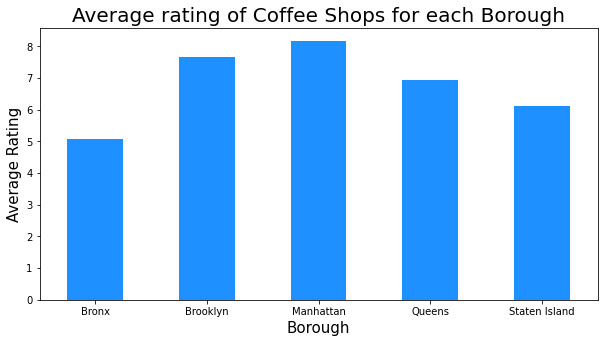

In [29]:
coffee_shop_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Coffee Shops for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [30]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
6,Boerum Hill,8.333333
8,Brooklyn Heights,8.600000
10,Carnegie Hill,8.225000
11,Carroll Gardens,8.183333
13,Chelsea,8.514286
14,Chinatown,9.100000
22,Ditmas Park,8.400000
24,Dumbo,8.600000
25,East Village,8.533333
26,East Williamsburg,8.200000


In [27]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Boerum Hill,40.685683,-73.983748,8.333333
1,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.600000
2,Manhattan,Carnegie Hill,40.782683,-73.953256,8.225000
3,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.183333
4,Manhattan,Chelsea,40.744035,-74.003116,8.514286
5,Staten Island,Chelsea,40.594726,-74.189560,8.514286
6,Manhattan,Chinatown,40.715618,-73.994279,9.100000
7,Brooklyn,Ditmas Park,40.643675,-73.961013,8.400000
8,Brooklyn,Dumbo,40.703176,-73.988753,8.600000
9,Manhattan,East Village,40.727847,-73.982226,8.533333


### Results / Conclusion

Manhattan has the best rated coffee shops restaurants on average. Bronx has the least amount of coffee shops per borough. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most coffee shops. Based on this information, I would state that Manhattan and Brooklyn are the best locations for coffee shops in NYC. To have the best shot of success, I would open a coffee shop in Brooklyn, since it has less competition than Manhattan, as well as smaller average rating. Finally, I would go to Midtown South in Manhattan for the best coffee, based on 2438 likes. As a final note, all of the above analysis is depended on the adequacy and accuracy of Foursquare data. A more comprehensive analysis and future work would need to incorporate data from other external databases.